# Telecom Churn

---

Решение конкурса на kaggle.com Это домашнее задание с курса [DLS](https://stepik.org/course/181974/info) посвящено полноценному решению задачи машинного обучения.

[Контест на Kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/). 

## 1. Description

---

* `train.csv`. На этом наборе данных нам необходимо создать и обучить модель. Подробное описание файла есть в ноутбуке.
* `test.csv`. В каждой строчке файла `test.csv` указаны признаки тестовых объектов. Предсказания для этого набора необходимо записать в файл submission.csv и сдать.

Данные: 
* [train.csv](https://drive.google.com/file/d/1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K/view?usp=share_link) - На этом наборе данных нам необходимо создать и обучить модель. Подробное описание файла есть в ноутбуке.
* [test.csv](https://drive.google.com/file/d/1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r/view?usp=share_link) - В каждой строчке файла `test.csv` указаны признаки тестовых объектов. 
* [submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link) - Предсказания для этого набора необходимо записать в файл submission.csv и сдать.

Если ссылки на данные не работают, их можно скачать [на Kaggle](https://www.kaggle.com/competitions/advanced-dls-spring-2021/data).

## 2. Metric

---

Перед решением любой задачи важно понимать, как будет оцениваться решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированны. Именно поэтому она очень удобна для соревнований.

## 3. Import Libraries

---

In [1]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

In [2]:
def seed_everything(seed) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

## 4. Download Data

---

In [3]:
# !gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
# !gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
# !gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

## 5. Data Analysis

---

### 5.1. Load Data

---

In [4]:
df_train = pd.read_csv('./data/train.csv')
print(f"Train shape: {df_train.shape}")

df_test = pd.read_csv('./data/test.csv')
print(f"Test shape: {df_test.shape}")
    
df_submission = pd.read_csv('./data/submission.csv')
print(f"Submission shape: {df_submission.shape}")

Train shape: (5282, 20)
Test shape: (1761, 19)
Submission shape: (1761, 2)


### 5.2. Data Overview

---

- Нам даны числовые и категориальные признаки. 

- Целевая переменная - **Churn**.

In [5]:
# Числовые признаки
num_cols = [
    "ClientPeriod",
    "MonthlySpending",
    "TotalSpent"
]

# Категориальные признаки
cat_cols = [
    "Sex",
    "IsSeniorCitizen",
    "HasPartner",
    "HasChild",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasInternetService",
    "HasOnlineSecurityService",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasTechSupportAccess",
    "HasOnlineTV",
    "HasMovieSubscription",
    "HasContractPhone",
    "IsBillingPaperless",
    "PaymentMethod"
]

feature_cols = num_cols + cat_cols
target_col = "Churn"

Посмотрим на данные:

In [6]:
df_train.sample(5)

ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
2600            72            92.30     6719.9    Male                0   
3348            22            84.15    1821.95  Female                0   
1049            68            53.00    3656.25  Female                1   
1970            72            91.95     6614.9    Male                0   
1789            54            30.40    1621.35    Male                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
2600        Yes       No             Yes                     Yes   
3348         No       No             Yes                     Yes   
1049        Yes      Yes              No        No phone service   
1970        Yes      Yes             Yes                     Yes   
1789        Yes       No              No        No phone service   

     HasInternetService HasOnlineSecurityService HasOnlineBackup  \
2600                DSL                      Yes             Yes   
3348        Fiber optic                       No              No   
1049                DSL                       No             Yes   
1970                DSL                      Yes             Yes   
1789                DSL                       No             Yes   

     HasDeviceProtection HasTechSupportAccess HasOnlineTV  \
2600                 Yes                  Yes         Yes   
3348                  No                   No         Yes   
1049                 Yes                   No         Yes   
1970                 Yes                  Yes         Yes   
1789                  No                   No          No   

     HasMovieSubscription HasContractPhone IsBillingPaperless  \
2600                  Yes         Two year                 No   
3348                   No   Month-to-month                Yes   
1049                  Yes         Two year                Yes   
1970                  Yes         Two year                Yes   
1789                   No   Month-to-month                 No   

                  PaymentMethod  Churn  
2600    Credit card (automatic)      0  
3348  Bank transfer (automatic)      0  
1049           Electronic check      0  
1970    Credit card (automatic)      0  
1789           Electronic check      0

**Наблюдения:**

1) Все признаки категориальные или числовые.
2) **ClientPeriod** --- сколько месяцев клиент пользуется услугами компании. Видимо, если клиент ушел, то этот признак равен количеству месяцев, которые он был клиентом.
3) **TotalSpent** --- сколько клиент заплатил компании за все время. Сумма не совпадает с произведением **ClientPeriod** и **MonthlySpending**. Видимо, в эту сумму входят какие-то дополнительные платежи или клиент не сделал какой-то последний платеж. Можно попробовать выделить разницу между **TotalSpent** и произведением **ClientPeriod** и **MonthlySpending** в отдельный признак.

### 5.3. Check for Duplicates

---

Проверим пропуски в данных и попробуем их обработать.

In [7]:
df_train.isnull().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

**Наблюдения:**

1) Видимых пропусков нет.
2) Необходимо проверить значения в столбцах, т.к. пропуски могут быть обозначены каким-то другим знаком.
3) Необходимо перевести столбец **TotalSpent** в числовой формат. Для этого проверим, какие значения помешали перевести столбец в числовой формат в самом начале.

### 5.4. Check for Duplicates

---

Проверим, есть ли дубликаты в данных:

In [9]:
df_train.duplicated().sum()

14

14 дубликатов. Посмотрим, что они из себя представляют:

In [10]:
df_train[df_train.duplicated(keep=False)].sort_values(by=feature_cols)

ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
838              1            19.65      19.65  Female                0   
1636             1            19.65      19.65  Female                0   
594              1            20.05      20.05    Male                0   
1474             1            20.05      20.05    Male                0   
3735             1            20.20       20.2    Male                0   
3749             1            20.20       20.2    Male                0   
1217             1            20.20       20.2    Male                0   
2586             1            20.20       20.2    Male                0   
2568             1            20.45      20.45    Male                0   
3660             1            20.45      20.45    Male                0   
2024             1            20.90       20.9  Female                0   
2991             1            20.90       20.9  Female                0   
1236             1            45.30       45.3    Male                0   
4530             1            45.30       45.3    Male                0   
7                1            45.70       45.7    Male                0   
1959             1            45.70       45.7    Male                0   
4373             1            69.20       69.2  Female                0   
4509             1            69.20       69.2  Female                0   
329              1            69.35      69.35    Male                0   
2036             1            69.35      69.35    Male                0   
409              1            69.60       69.6  Female                1   
5041             1            69.60       69.6  Female                1   
170              1            69.90       69.9    Male                0   
1384             1            69.90       69.9    Male                0   
1898             1            70.10       70.1  Female                0   
2877             1            70.10       70.1  Female                0   
1068             1            70.15      70.15  Female                0   
4276             1            70.15      70.15  Female                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
838          No       No             Yes                      No   
1636         No       No             Yes                      No   
594          No       No             Yes                      No   
1474         No       No             Yes                      No   
3735         No       No             Yes                      No   
3749         No       No             Yes                      No   
1217         No       No             Yes                      No   
2586         No       No             Yes                      No   
2568         No       No             Yes                      No   
3660         No       No             Yes                      No   
2024         No       No             Yes                      No   
2991         No       No             Yes                      No   
1236         No       No             Yes                      No   
4530         No       No             Yes                      No   
7            No       No             Yes                      No   
1959         No       No             Yes                      No   
4373         No       No             Yes                      No   
4509         No       No             Yes                      No   
329          No       No             Yes                      No   
2036         No       No             Yes                      No   
409          No       No             Yes                      No   
5041         No       No             Yes                      No   
170          No       No             Yes                      No   
1384         No       No             Yes                      No   
1898         No       No             Yes                      No   
2877         No       No             Yes                      

**Наблюдения:**

1) Все дубли относятся клиентам, которые пользуются услугами компании 1 месяц и совершившие ровно 1 платеж. Видимо, это новые или тестовые клиенты. Пока можем оставить их из-за небольшого количества.

### 5.5. Format Data

---

#### 5.5.1. Numerical Features

---

Ранее мы заметили, что столбец **TotalSpent** не является числовым. Посмотрим, какие значения помешали перевести столбец в числовой формат в самом начале:

In [11]:
df_train.TotalSpent.apply(lambda x: not str(x).strip().split(".")[0].isdigit()).sum()

9

Видимо 9 значений в колонке не являются числами. Посмотрим на них:

In [12]:
df_train[df_train.TotalSpent.apply(lambda x: not str(x).strip().split(".")[0].isdigit())]

ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
1048             0            25.75               Male                0   
1707             0            73.35             Female                0   
2543             0            19.70               Male                0   
3078             0            80.85             Female                0   
3697             0            20.00             Female                0   
4002             0            61.90               Male                0   
4326             0            25.35               Male                0   
4551             0            52.55             Female                0   
4598             0            56.05             Female                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
1048        Yes      Yes             Yes                     Yes   
1707        Yes      Yes             Yes                     Yes   
2543        Yes      Yes             Yes                      No   
3078        Yes      Yes             Yes                      No   
3697        Yes      Yes             Yes                      No   
4002         No      Yes             Yes                     Yes   
4326        Yes      Yes             Yes                     Yes   
4551        Yes      Yes              No        No phone service   
4598        Yes      Yes              No        No phone service   

     HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
1048                 No      No internet service  No internet service   
1707                DSL                       No                  Yes   
2543                 No      No internet service  No internet service   
3078                DSL                      Yes                  Yes   
3697                 No      No internet service  No internet service   
4002                DSL                      Yes                  Yes   
4326                 No      No internet service  No internet service   
4551                DSL                      Yes                   No   
4598                DSL                      Yes                  Yes   

      HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
1048  No internet service  No internet service  No internet service   
1707                  Yes                  Yes                  Yes   
2543  No internet service  No internet service  No internet service   
3078                  Yes                   No                  Yes   
3697  No internet service  No internet service  No internet service   
4002                   No                  Yes                   No   
4326  No internet service  No internet service  No internet service   
4551                  Yes                  Yes                  Yes   
4598                  Yes                  Yes                  Yes   

     HasMovieSubscription HasContractPhone IsBillingPaperless  \
1048  No internet service         Two year                 No   
1707                   No         Two year                 No   
2543  No internet service         One year                Yes   
3078                  Yes         Two year                 No   
3697  No internet service         Two year                 No   
4002                   No         Two year                Yes   
4326  No internet service         Two year                 No   
4551                   No         Two year                Yes   
4598                   No         Two year                 No   

                  PaymentMethod  Churn  
1048               Mailed check      0  
1707               Mailed check      0  
2543               Mailed check      0  
3078               Mailed check      0  
3697               Mailed check      0  
4002  Bank transfer (automatic)      0  
4326               Mailed check      0  
4551  Bank transfer (automatic)      0  
4598    Credit card (automatic)      0

In [13]:
df_train[df_train.ClientPeriod < 1].Churn.value_counts()

Churn
0    9
Name: count, dtype: int64

**Наблюдения:**

1. Все "дефектные" значения в столбце **TotalSpent** относятся к клиентам, которые пользуются услугами компании меньше 1 месяц из-за чего у них нет платежей. Поэтому, скорее всего, эти значения можно заменить на 0.
2. У всей выборки значение **Churn** равно 0. Скорее всего, это новые клиенты с долгосрочными контрактами, которым мы можем присваивать 100% вероятность того, что они останутся.

Переведем наши значения в числовой формат и применим предыдущие наблюдения к тестовым данным:

In [14]:
def refactor_num_data(df_: pd.DataFrame) -> pd.DataFrame:
    df_.TotalSpent = df_.TotalSpent.apply(lambda x: "0" if x == " " else x)
    df_.TotalSpent = pd.to_numeric(df_.TotalSpent, downcast="float").apply(lambda x: np.round(x, 2))
    df_.MonthlySpending = pd.to_numeric(df_.MonthlySpending, downcast="float").apply(lambda x: np.round(x, 2))
    
    df_.ClientPeriod = pd.to_numeric(df_.ClientPeriod, downcast="integer")
    df_.IsSeniorCitizen = pd.to_numeric(df_.IsSeniorCitizen, downcast="integer")
    if "Churn" in df_.columns:  # Делаем проверку, т.к. в тестовых данных нет столбца Churn
        df_.Churn = pd.to_numeric(df_.Churn, downcast="integer")
    
    df_["DiffTotalSpent"] = np.round(df_.TotalSpent - df_.ClientPeriod * df_.MonthlySpending, 2)
    if "DiffTotalSpent" not in num_cols:
        num_cols.append("DiffTotalSpent")
    
    return df_

In [15]:
df_train = refactor_num_data(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int8   
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int8   
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [16]:
df_train.head(10)

ClientPeriod  MonthlySpending  TotalSpent     Sex  IsSeniorCitizen  \
0            55            19.50     1026.35    Male                0   
1            72            25.85     1872.20    Male                0   
2             1            75.90       75.90    Male                0   
3            32            79.30     2570.00  Female                1   
4            60           115.25     6758.45  Female                0   
5            25            19.80      475.20  Female                0   
6            27            90.15     2423.40  Female                0   
7             1            45.70       45.70    Male                0   
8            50           105.95     5341.80    Male                0   
9            72            61.20     4390.25    Male                0   

  HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
0        Yes      Yes             Yes                      No   
1        Yes       No             Yes                     Yes   
2         No       No             Yes                      No   
3        Yes       No             Yes                     Yes   
4        Yes      Yes             Yes                     Yes   
5         No       No             Yes                      No   
6        Yes       No             Yes                     Yes   
7         No       No             Yes                      No   
8        Yes      Yes             Yes                     Yes   
9         No       No              No        No phone service   

  HasInternetService  ...      HasOnlineBackup  HasDeviceProtection  \
0                 No  ...  No internet service  No internet service   
1                 No  ...  No internet service  No internet service   
2        Fiber optic  ...                   No                   No   
3        Fiber optic  ...                   No                  Yes   
4        Fiber optic  ...                  Yes                  Yes   
5                 No  ...  No internet service  No internet service   
6        Fiber optic  ...                   No                  Yes   
7                DSL  ...                   No                   No   
8        Fiber optic  ...                   No                  Yes   
9                DSL  ...                   No                  Yes   

  HasTechSupportAccess          HasOnlineTV HasMovieSubscription  \
0  No internet service  No internet service  No internet service   
1  No internet service  No internet service  No internet service   
2                  Yes                   No                   No   
3                   No                   No                   No   
4                  Yes                  Yes                  Yes   
5  No internet service  No internet service  No internet service   
6                   No                   No                  Yes   
7                   No                   No                   No   
8                   No                  Yes                  Yes   
9                  Yes                  Yes                  Yes   

  HasContractPhone IsBillingPaperless              PaymentMethod Churn  \
0         One year                 No               Mailed check     0   
1         Two year                 No    Credit card (automatic)     0   
2   Month-to-month                Yes           Electronic check     1   
3   Month-to-month                 No               Mailed check     0   
4         Two year                 No    Credit card (automatic)     0   
5         Two year                 No    Credit card (automatic)     0   
6   Month-to-month                 No  Bank transfer (automatic)     0   
7   Month-to-month                Yes               Mailed check     1   
8   Month-to-month                 No    Credit card (automatic)     1   
9         Two year                Yes    Credit card (automatic)     0   

   DiffTotalSpent  
0          -46.15  
1           11.00  
2            0.00  
3           32.40  
4         -156.55  
5          -19.80

**Наблюдения:**
1. Появилась гипотеза, что **DiffTotalSpent** может быть связан с целевой переменной. 

Выделим 3 группы клиентов:
    - **DiffTotalSpent** < 0
    - **DiffTotalSpent** = 0
    - **DiffTotalSpent** > 0
И посмотрим на корреляцию числовых признаков:

In [17]:
data = df_train.copy()
data["DiffTotalSpentGroup"] = data.DiffTotalSpent.apply(lambda x: "less" if x < 0 else "equal" if x == 0 else "more")
data[["DiffTotalSpentGroup", "Churn"]].groupby("DiffTotalSpentGroup").agg(["mean", "count"])

Churn      
                         mean count
DiffTotalSpentGroup                
equal                0.605996   467
less                 0.223137  2429
more                 0.234283  2386

**Наблюдения:**

1. Есть явная взаимосвязь, которая говорит нам о том, что при **DiffTotalSpent** равном 0, клиенты уходят. Вероятно, перед уходом клиенты закрывают все задолженности или стараются максимально использовать уже оплаченные, чтобы не терять деньги.
2. Создадим отдельный столбец **IsDiffTotalSpentZero** в категориальных признаках.

#### 5.5.2. Categorical Features

---

Посмотрим на уникальные значения категориальных признаков:

In [18]:
def iter_object_cols_info(df_: pd.DataFrame) -> None:

    def _print_col_info(col_: str) -> list:
        dct = {val_: df_[df_[col_] == val_].shape[0] for val_ in df_[col_].unique()}
        max_len = max(max(map(len, dct.keys())), len(col_))
        lst = sorted(dct.items(), key=lambda x_: x_[1], reverse=True)
        
        lst_print = [f"{col_:<{max_len + 1}}: {df_[col_].nunique():>2} unique values"]
        lst_print.extend([f" {val:<{max_len}}: {cnt:>5} ({cnt / df_.shape[0] * 100:.2f}%)" for val, cnt in lst])
        
        return lst_print
        
    print("=" * 50)
    for col in df_.select_dtypes(object).columns:
        print(*_print_col_info(col), sep="\n")
        print("=" * 50)

In [19]:
iter_object_cols_info(df_train)

Sex    :  2 unique values
 Male  :  2655 (50.27%)
 Female:  2627 (49.73%)
HasPartner :  2 unique values
 No        :  2705 (51.21%)
 Yes       :  2577 (48.79%)
HasChild :  2 unique values
 No      :  3676 (69.59%)
 Yes     :  1606 (30.41%)
HasPhoneService :  2 unique values
 Yes            :  4761 (90.14%)
 No             :   521 (9.86%)
HasMultiplePhoneNumbers :  3 unique values
 No                     :  2511 (47.54%)
 Yes                    :  2250 (42.60%)
 No phone service       :   521 (9.86%)
HasInternetService :  3 unique values
 Fiber optic       :  2341 (44.32%)
 DSL               :  1800 (34.08%)
 No                :  1141 (21.60%)
HasOnlineSecurityService :  3 unique values
 No                      :  2612 (49.45%)
 Yes                     :  1529 (28.95%)
 No internet service     :  1141 (21.60%)
HasOnlineBackup     :  3 unique values
 No                 :  2332 (44.15%)
 Yes                :  1809 (34.25%)
 No internet service:  1141 (21.60%)
HasDeviceProtection :  3 uniq

**Наблюдения:**

1) Кол-во признаков: в 5 столбцах всего 2 уникальных значения, в 9 столбцах 3 уникальных значения, в 1 столбце 4 уникальных значения.
2) В столбце **HasMultiplePhoneNumbers** есть значение 'No phone service", которое, дублирует значение **HasPhoneService**. Заменим его на "No", т.к. это в данном случае означает то же самое.
3) То же самое со значениями "No internet service" в столбцах **HasOnlineSecurityService**, **HasOnlineBackup**, **HasDeviceProtection**, **HasTechSupportAccess**, **HasOnlineTV**, **HasMovieSubscription**. Заменим их на "No", т.к. они дублируют значения **HasInternetService**.
4) Многие признаки имеют значения "No" и "Yes". Заменим их на 0 и 1 соответственно.
5) В столбце **PaymentMethod** есть значения с припиской "(automatic)". Удалим ее, создав отдельный столбец **IsAutomaticPayment** со значениями 0 и 1.

In [20]:
df_train.loc[:, df_train.columns.isin([col for col in df_train.columns if df_train[col].nunique() == 2])]

Sex  IsSeniorCitizen HasPartner HasChild HasPhoneService  \
0       Male                0        Yes      Yes             Yes   
1       Male                0        Yes       No             Yes   
2       Male                0         No       No             Yes   
3     Female                1        Yes       No             Yes   
4     Female                0        Yes      Yes             Yes   
...      ...              ...        ...      ...             ...   
5277    Male                0         No       No              No   
5278    Male                0        Yes       No              No   
5279    Male                0         No       No             Yes   
5280  Female                0         No       No             Yes   
5281  Female                0         No      Yes             Yes   

     IsBillingPaperless  Churn  
0                    No      0  
1                    No      0  
2                   Yes      1  
3                    No      0  
4                    No      0  
...                 ...    ...  
5277                 No      0  
5278                Yes      0  
5279                 No      0  
5280                Yes      0  
5281                Yes      0  

[5282 rows x 7 columns]

In [21]:
def refactor_cat_data(df_: pd.DataFrame) -> pd.DataFrame:
    df_ = df_.replace({"No phone service": "No", "No internet service": "No"})
    df_.HasInternetService = df_.HasInternetService.replace({"No": "No internet service"})

    df_["IsDiffTotalSpentZero"] = df_.DiffTotalSpent.apply(lambda x: "Yes" if x == 0 else "No")
    if "IsDiffTotalSpentZero" not in cat_cols:
        cat_cols.append("IsDiffTotalSpentZero")

    df_["IsAutomaticPayment"] = df_.PaymentMethod.apply(lambda x: "Yes" if x.endswith("(automatic)") else "No")
    df_.PaymentMethod = df_.PaymentMethod.str.replace(" (automatic)", "")
    if "IsAutomaticPayment" not in cat_cols:
        cat_cols.append("IsAutomaticPayment")
    
    mask = df_.columns.isin([col for col in cat_cols if (df_[col].nunique() == 2) and ("Yes" in df_[col].unique())])
    for col in df_.loc[:, mask].columns:
        df_[col] = pd.to_numeric(df_[col].replace({"No": 0, "Yes": 1}), downcast="integer")
    
    for col in df_.select_dtypes(object).columns:
        df_[col] = df_[col].astype("category")
    
    return df_

df_train = refactor_cat_data(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ClientPeriod              5282 non-null   int8    
 1   MonthlySpending           5282 non-null   float64 
 2   TotalSpent                5282 non-null   float64 
 3   Sex                       5282 non-null   category
 4   IsSeniorCitizen           5282 non-null   int8    
 5   HasPartner                5282 non-null   int8    
 6   HasChild                  5282 non-null   int8    
 7   HasPhoneService           5282 non-null   int8    
 8   HasMultiplePhoneNumbers   5282 non-null   int8    
 9   HasInternetService        5282 non-null   category
 10  HasOnlineSecurityService  5282 non-null   int8    
 11  HasOnlineBackup           5282 non-null   int8    
 12  HasDeviceProtection       5282 non-null   int8    
 13  HasTechSupportAccess      5282 non-null   int8  

In [22]:
df_train.head()

ClientPeriod  MonthlySpending  TotalSpent     Sex  IsSeniorCitizen  \
0            55            19.50     1026.35    Male                0   
1            72            25.85     1872.20    Male                0   
2             1            75.90       75.90    Male                0   
3            32            79.30     2570.00  Female                1   
4            60           115.25     6758.45  Female                0   

   HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
0           1         1                1                        0   
1           1         0                1                        1   
2           0         0                1                        0   
3           1         0                1                        1   
4           1         1                1                        1   

    HasInternetService  ...  HasTechSupportAccess  HasOnlineTV  \
0  No internet service  ...                     0            0   
1  No internet service  ...                     0            0   
2          Fiber optic  ...                     1            0   
3          Fiber optic  ...                     0            0   
4          Fiber optic  ...                     1            1   

   HasMovieSubscription  HasContractPhone  IsBillingPaperless  \
0                     0          One year                   0   
1                     0          Two year                   0   
2                     0    Month-to-month                   1   
3                     0    Month-to-month                   0   
4                     1          Two year                   0   

      PaymentMethod Churn  DiffTotalSpent IsDiffTotalSpentZero  \
0      Mailed check     0          -46.15                    0   
1       Credit card     0           11.00                    0   
2  Electronic check     1            0.00                    1   
3      Mailed check     0           32.40                    0   
4       Credit card     0         -156.55                    0   

   IsAutomaticPayment  
0                   0  
1                   1  
2                   0  
3                   0  
4                   1  

[5 rows x 23 columns]

### 5.6. Visual Analysis

---

Посмотрим на распределение числовых и категориальных признаков, а также на распределение целевой переменной.

In [23]:
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

%matplotlib inline

#### 5.6.1. Numerical Features

---

In [24]:
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] = "white"

plt_config_num = dict(
    palette="coolwarm",
    hue=target_col, 
    hue_order=[1, 0]
)

In [25]:
def plot_num_data(df_: pd.DataFrame, cols_: list) -> None:
    fig, axes = plt.subplots(nrows=len(cols_), ncols=2, figsize=(15, 15))
    for col, ax in zip(cols_, axes):
        sns.histplot(
            df_,
            x=col,
            alpha=0.7,
            ax=ax[0],
            bins=len(df_[col].unique()) // 2,
            binrange=(df_[col].min(), df_[col].max()),
            kde=True,
            **plt_config_num
        )

        sns.boxplot(
            df_,
            x=col,
            vert=False,
            ax=ax[1],
            **plt_config_num
        )
    
        for ax_ in ax:
            ax_.set_title(col)
            ax_.set_xlabel("Value")
            ax_.set_ylabel("Count")
    
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

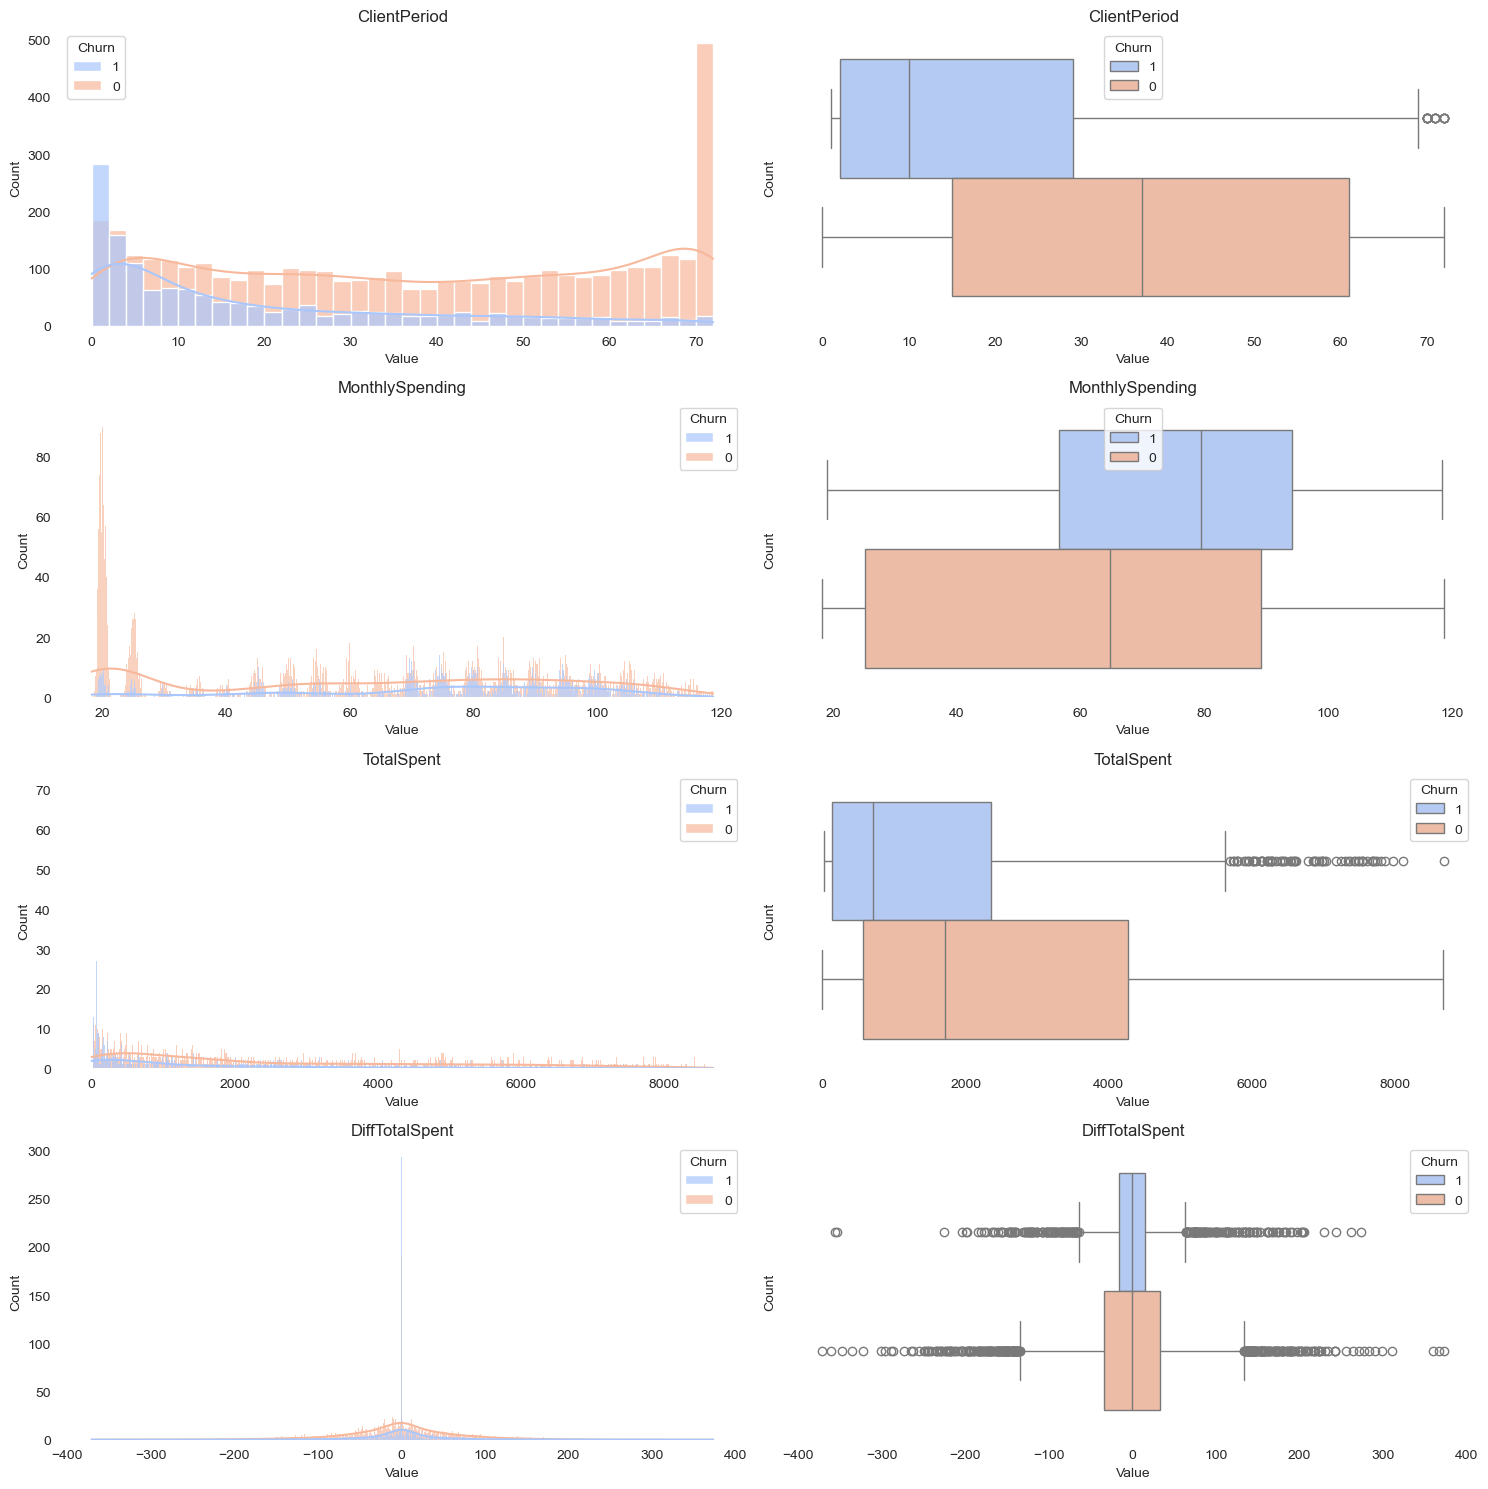

In [26]:
plot_num_data(df_train, num_cols)

**Наблюдения:**

1) У числовых признаков в данных есть смещение влево. Попробуем прологарифмировать их.
2) Судя по графику **ClientPeriod**, чем больше клиент пользуется услугами компании, тем меньше вероятность, что он уйдет. Возможно, это связано с тем, что чем дольше клиент пользуется услугами компании, тем сложнее ему перейти к новому оператору (консерватизм).
3) В то же время, верно и обратное - чем меньше клиент пользуется услугами компании, тем больше вероятность, что он уйдет. Первые 20 месяцев мобильному оператору нужно уделять особое внимание клиентам, т.к. именно в этот период вероятность оттока клиента максимальна.
4) На графике **MonthlySpending** можем заметить, что чем больше клиент платит за услуги компании, тем больше вероятность, что он уйдет. Скорее всего, с возрастанием стоимости услуг, клиенты начинают искать более выгодные предложения.
5) По графику **TotalSpent** сложно сделать какие-то выводы. Видно, что из-за предыдущих двух признаков, ведь уходя клиенты платят меньше, а оставшиеся клиенты платят больше.
6) График **DiffTotalSpent** подтверждает наши предположения о том, что при **DiffTotalSpent** равном 0, клиенты уходят.

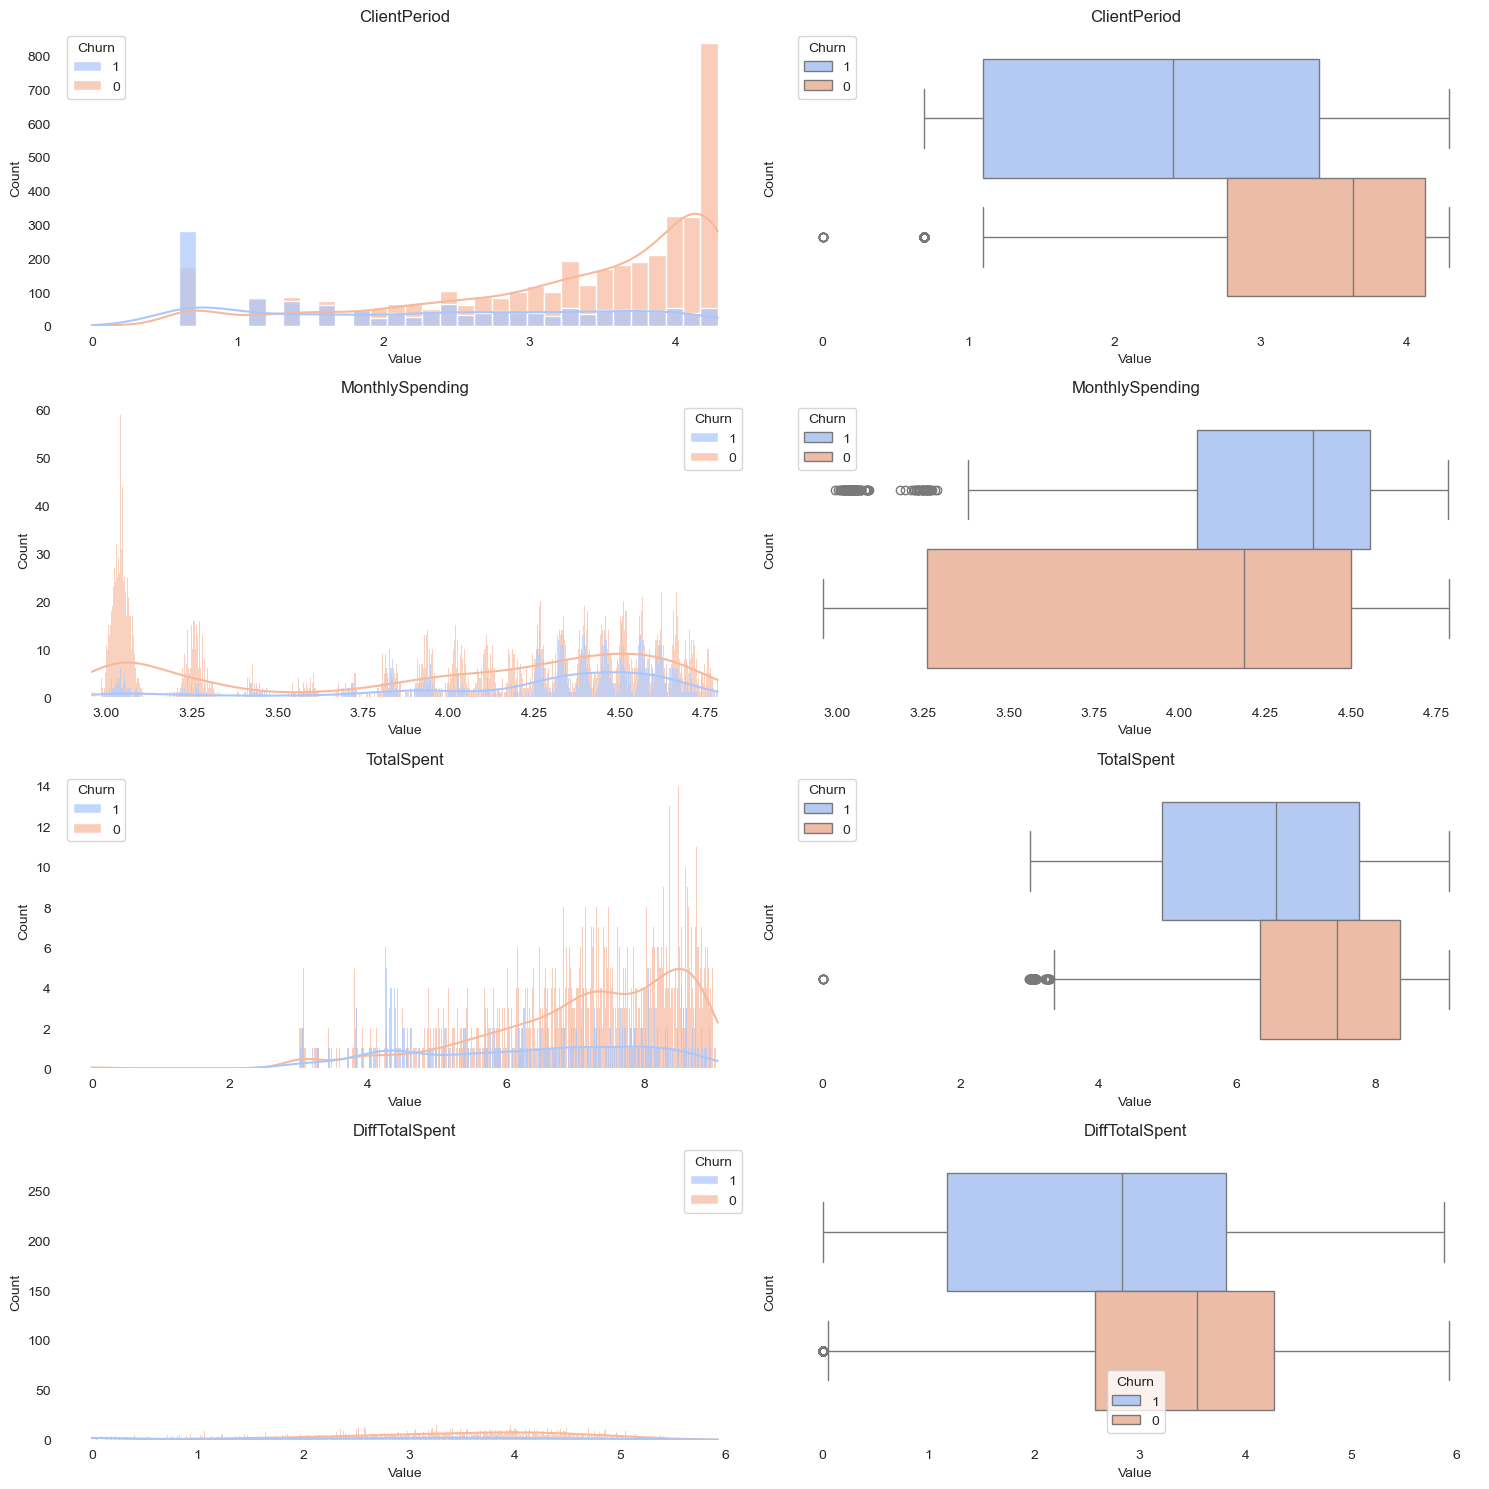

In [27]:
def log_transform(df_: pd.DataFrame, cols_: list) -> pd.DataFrame:
    for col in cols_:
        df_[col] = np.log(np.abs(df_[col]) + 1)
    return df_


plot_num_data(log_transform(df_train.copy(), num_cols), num_cols)

**Наблюдения:**

1) После логарифмирования числовых признаков, смещение влево стало скошенностью вправо.
2) Как и предполагалось, совсем новые клиенты, которые пользуются услугами меньше 1 месяца, не уходят. Вероятно, это связано с тем, что они еще не успели оценить качество услуг компании (особенно, если они заключили долгосрочный контракт).
3) Абоненты, которые ушли, имея небольшую ежемесячную плату - больше похожи на исключение, чем на правило.

In [28]:
print(f"Кол-во клиентов, которые пользуются услугами компании меньше 1 месяца: {df_train[df_train.ClientPeriod < 1].shape[0]}")
print(f"Кол-во клиентов, которые ушли, имея небольшую ежемесячную плату: {df_train[(df_train.MonthlySpending < 20) & (df_train.Churn == 1)].shape[0]}")

Кол-во клиентов, которые пользуются услугами компании меньше 1 месяца: 9
Кол-во клиентов, которые ушли, имея небольшую ежемесячную плату: 39


**Гипотеза 1:**
Проверим гипотезу о том, что в первые месяцы, вероятность ухода клиента наивысшая:

In [29]:
def plot_hist_prob(df_: pd.DataFrame, col_: str) -> None:
    
    plt.figure(figsize=(15, 3))
    
    sns.histplot(
        df_,
        x=col_,
        alpha=0.7,
        bins=len(df_[col_].unique()),
        binrange=(df_[col_].min(), df_[col_].max()),
        kde=True,
        stat="probability",
        element="step",
        cbar=True,
        cbar_kws=dict(shrink=0.8),
        fill=False,
        linewidth=2,
        **plt_config_num
    )
    
    plt.title(f"{target_col} by {col_}")
    plt.xlabel(col_)
    plt.ylabel(target_col)
    plt.show()

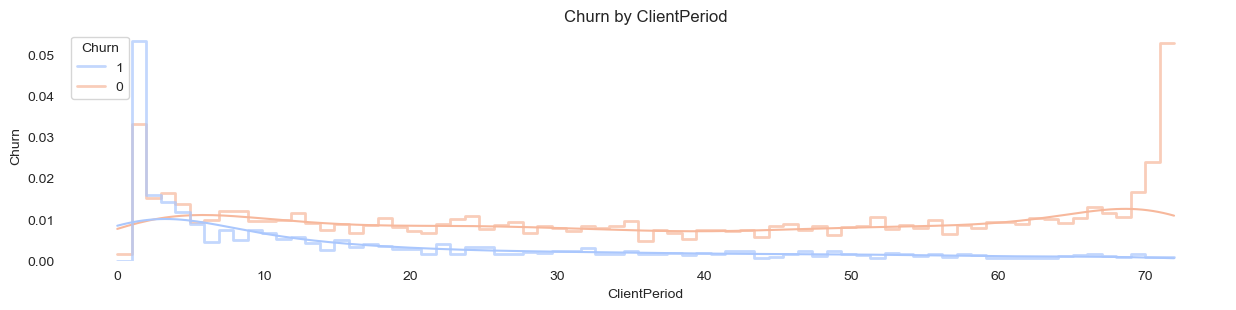

In [30]:
plot_hist_prob(df_train, "ClientPeriod")

Гипотеза подтвердилась. После первого месяца, вероятность ухода клиента наивысшая.

**Гипотеза 2:**
Проверим обратную гипотезу о том, что после определенного кол-ва месяцев, вероятность ухода клиента уменьшается:

In [31]:
def plot_hist_camul_prob(df_: pd.DataFrame, col_: str) -> None:

    plt.figure(figsize=(15, 3))

    sns.histplot(
        df_,
        x=col_,
        alpha=0.7,
        bins=len(df_[col_].unique()),
        binrange=(df_[col_].min(), df_[col_].max()),
        kde=True,
        **plt_config_num,
        stat="probability",
        element="step",
        cbar=True,
        cbar_kws=dict(shrink=0.8),
        fill=False,
        linewidth=2,
        cumulative=True
    )

    plt.title(f"{target_col} by {col_}")
    plt.xlabel(col_)
    plt.ylabel(target_col)
    plt.show()

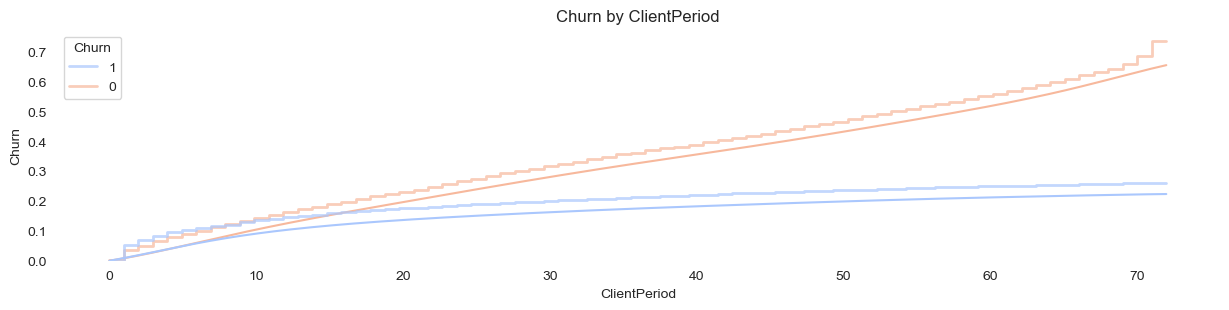

In [32]:
plot_hist_camul_prob(df_train, "ClientPeriod")

Гипотеза подтвердилась. Примерно после 16-17 месяцев, вероятность того, что клиент не уйдет, возрастает.

**Гипотеза 3:**
Проверим гипотезу о том, что после определенного значения **TotalSpent**, вероятность ухода клиента уменьшается:

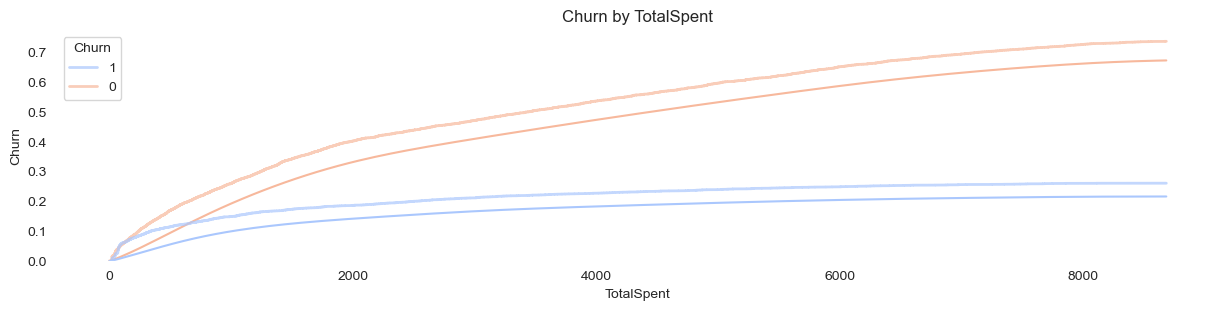

In [33]:
plot_hist_camul_prob(df_train.copy(), "TotalSpent")

Как видим, начиная со значения **TotalSpent** ~ 1 000, вероятность того, что клиент не уйдет, возрастает.

#### 5.6.2. Categorical Features

---

In [34]:
plt_config_bar = dict(
    linewidth=2,
    edgecolor="0.2",
    saturation=1,
    alpha=0.8
)

plt_config_pie = dict(
    labeldistance=1.1,
    rotatelabels=True,
    autopct="%1.1f%%",
    pctdistance=0.75,
    wedgeprops=dict(width=0.8, edgecolor="white", linewidth=1, antialiased=True),
    textprops=dict(color="black", fontsize=10, fontweight="bold", alpha=0.8),
    startangle=90,
    shadow=True
)

In [35]:
def plot_cat_data(df_: pd.DataFrame, cols_: list, fig_size_: tuple = (12, 60)) -> None:
    fig, axes = plt.subplots(nrows=len(cols_), ncols=2, figsize=fig_size_)
    for col, ax in zip(cols_, axes):
        value_count = df_[col].value_counts()
        colors = cm.get_cmap("coolwarm")(np.linspace(0.8, 0.2, df_[col].nunique()))
        colors_dct = {str(val): colors[ind] for ind, val in enumerate(value_count.index)}
        explode = [0.1 if val == value_count.max() else (0 + ind / 20) for ind, val in enumerate(value_count)]

        sns.barplot(
            x=value_count.index, 
            y=value_count.values,
            palette=colors_dct,
            **plt_config_bar,
            ax=ax[0]
        )
        ax[0].set_title(col)
        ax[0].set_xlabel("Value")
        ax[0].set_ylabel("Count")

        ax[1].pie(
            value_count.values, 
            labels=colors_dct.keys(),
            explode=explode,
            colors=colors_dct.values(),
            **plt_config_pie
        )
        ax[1].set_title(col)

        ax[1].add_artist(plt.Circle((0,0), 0.5, fc="white"))

    sns.despine(left=True, bottom=True)
    plt.grid(axis="y", alpha=0)
    plt.grid(axis="x", alpha=0)
    plt.tight_layout()
    plt.show()

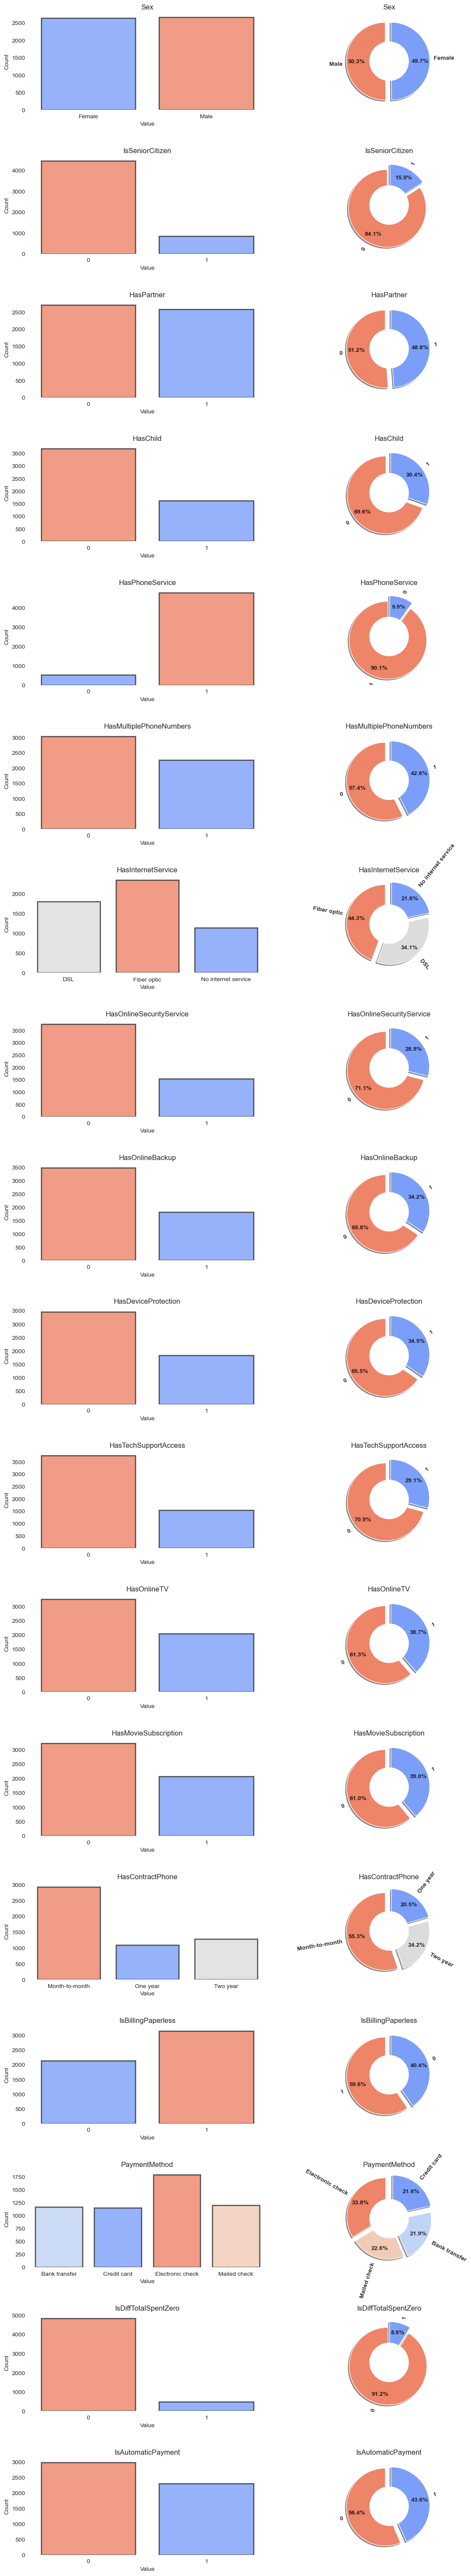

In [36]:
plot_cat_data(df_train, cat_cols)

**Наблюдения:**

1. Плохо сбалансированные признаки: **IsSeniorCitizen**, **HasPhoneService**, **IsDiffTotalSpentZero**. Нужно будет учесть это при обучении модели.

**Гипотеза 4:**
В распределении **TotalSpent** мы наблюдали цикличный рост вероятности ухода клиента. Возможно это связано с тем, что клиенты заключают долгосрочные контракты. 

Создадим промежуточный признак **ClientPeriodContract**, где запишем кол-во месяцев по контракту.
Затем создадим новый признак **ClientPeriodDiff**, в которой посчитаем кол-во месяцев оставшихся до конца контракта. 
Те, у кого оплата ежемесячно, мы ставим 1. Остальным, мы считаем кол-во месяцев, которые остались до конца контракта. Если число месяцев в **ClientPeriod** больше, чем в **ClientPeriodContract**, то мы берем остаток от деления **ClientPeriod** на **ClientPeriodContract**, так как, скорее всего, клиент продлил контракт. 
Если же число месяцев в **ClientPeriod** меньше, чем в **ClientPeriodContract**, то мы берем значение из **ClientPeriodContract**, так как, скорее всего, клиент заключил новый контракт.

Дополнительно для анализа добавим кол-во циклов контракта в столбец **CountContract**. Будем считать, включая текущий, чтобы проверить корреляцию с целевой переменной.
И столбец **TotalDiffSpent**, в котором посчитаем разницу между **TotalSpent** и произведением **ClientPeriodDiff** и **MonthlySpending**. Сумма, которую клиент должен был заплатить, в течении оставшихся месяцев до конца контракта.

In [37]:
def refactor_client_period(df_: pd.DataFrame) -> pd.DataFrame:
    df_["ClientPeriodContract"] = df_.HasContractPhone.apply(lambda x: 12 if x == "One year" else (24 if x == "Two year" else 1))
    df_.ClientPeriodContract = pd.to_numeric(df_.ClientPeriodContract, downcast="integer")
    # if "ClientPeriodContract" not in num_cols:
    #     num_cols.append("ClientPeriodContract")

    mask = df_.ClientPeriodContract > 1
    
    df_["ClientPeriodDiff"] = 0
    mask_1 = mask, "ClientPeriodDiff"
    mask_2 = mask, ["ClientPeriod", "ClientPeriodContract"]
    df_.loc[mask_1] = df_.loc[mask_2].apply(lambda x: (x[0] % x[1]) if x[0] > 1 else x[1], axis=1)
    # if "ClientPeriodDiff" not in num_cols:
    #     num_cols.append("ClientPeriodDiff")

    df_["CountContract"] = df_.ClientPeriod
    mask_1 = mask, "CountContract"
    df_.loc[mask_1] = df_.loc[mask_2].apply(lambda x: np.ceil(x[0] / x[1]), axis=1)
    
    df_["TotalDiffSpent"] = np.round(df_.TotalSpent - df_.ClientPeriodDiff * df_.MonthlySpending, 2)
    return df_

df_train = refactor_client_period(df_train.copy())
df_train[["ClientPeriod", "ClientPeriodContract", "ClientPeriodDiff", "CountContract", "TotalDiffSpent", "Churn"]].head(10)

ClientPeriod  ClientPeriodContract  ClientPeriodDiff  CountContract  \
0            55                    12                 7              5   
1            72                    24                 0              3   
2             1                     1                 0              1   
3            32                     1                 0             32   
4            60                    24                12              3   
5            25                    24                 1              2   
6            27                     1                 0             27   
7             1                     1                 0              1   
8            50                     1                 0             50   
9            72                    24                 0              3   

   TotalDiffSpent  Churn  
0          889.85      0  
1         1872.20      0  
2           75.90      1  
3         2570.00      0  
4         5375.45      0  
5          455.40      0  
6         2423.40      0  
7           45.70      1  
8         5341.80      1  
9         4390.25      0

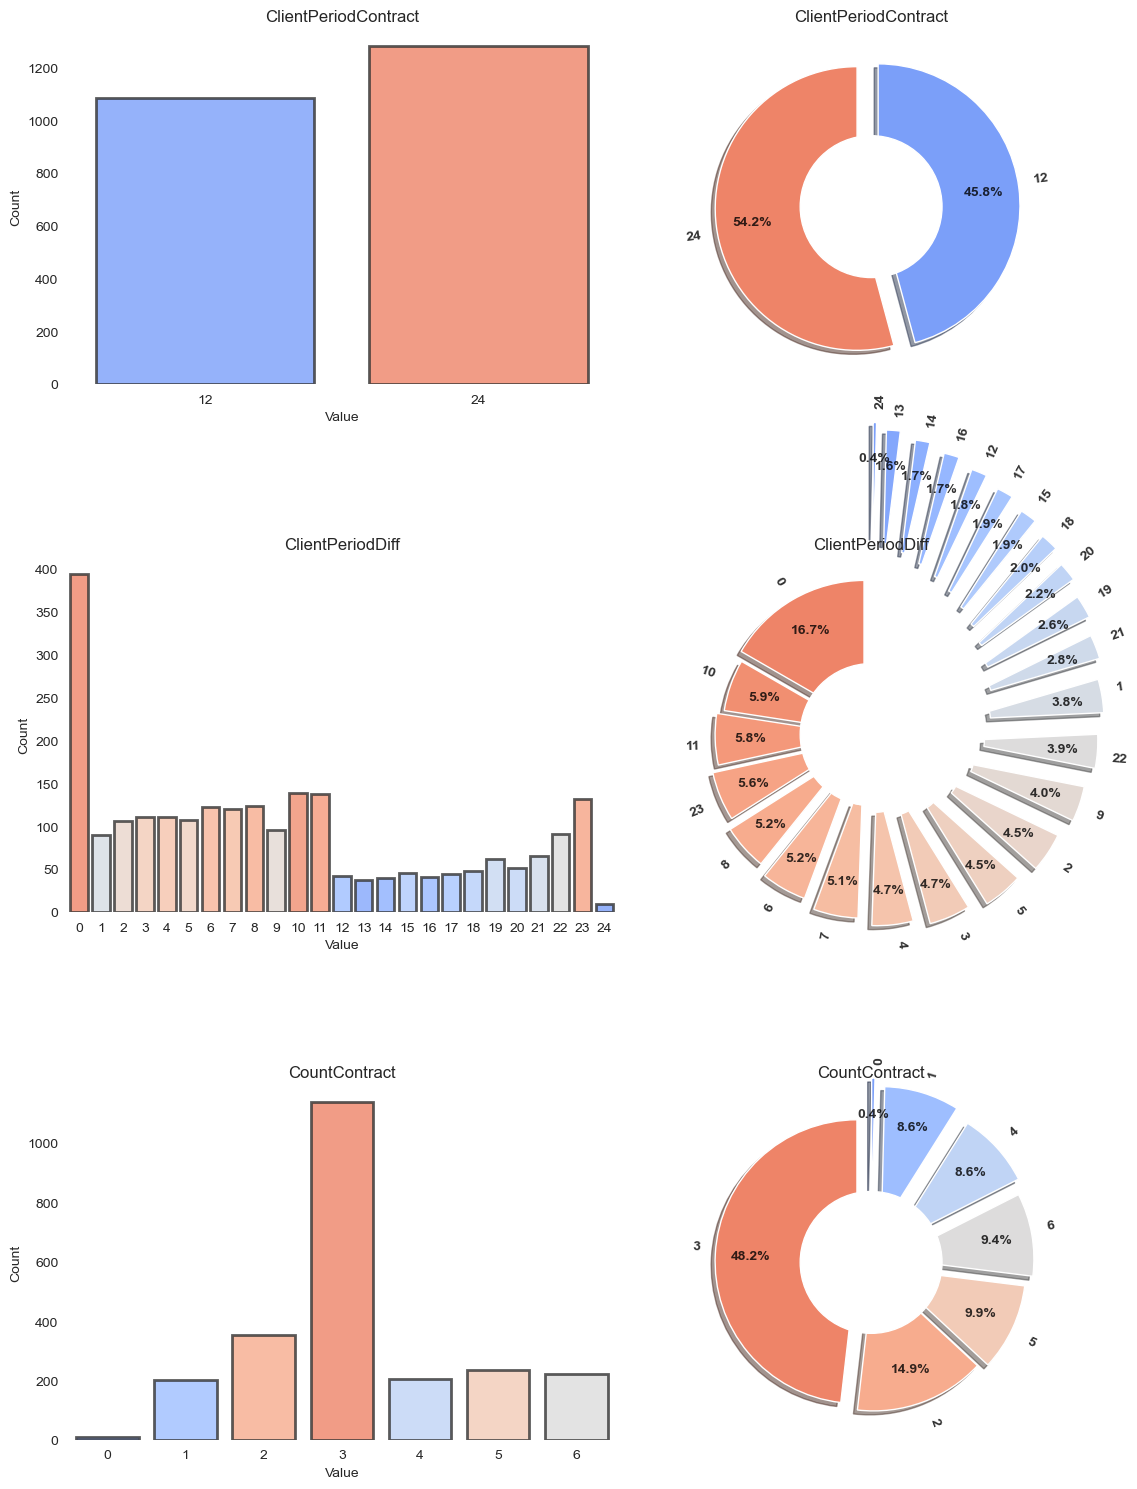

In [38]:
plot_cat_data(df_train[df_train.ClientPeriodContract > 1], ["ClientPeriodContract", "ClientPeriodDiff", "CountContract"], (12, 15))

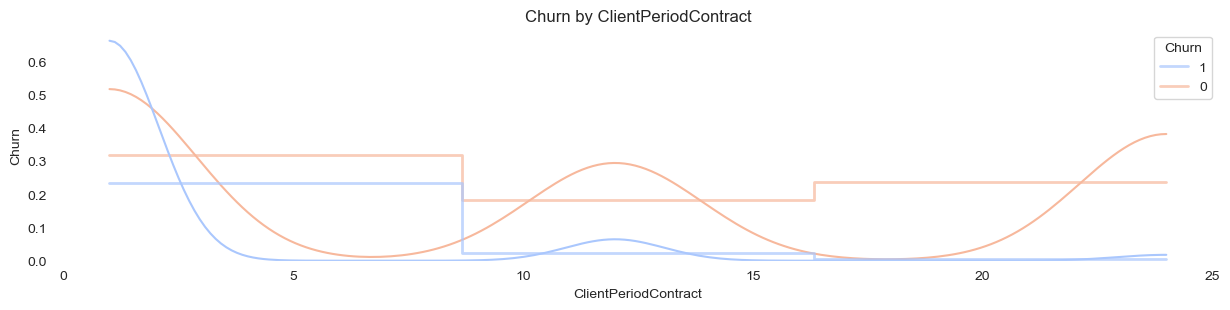

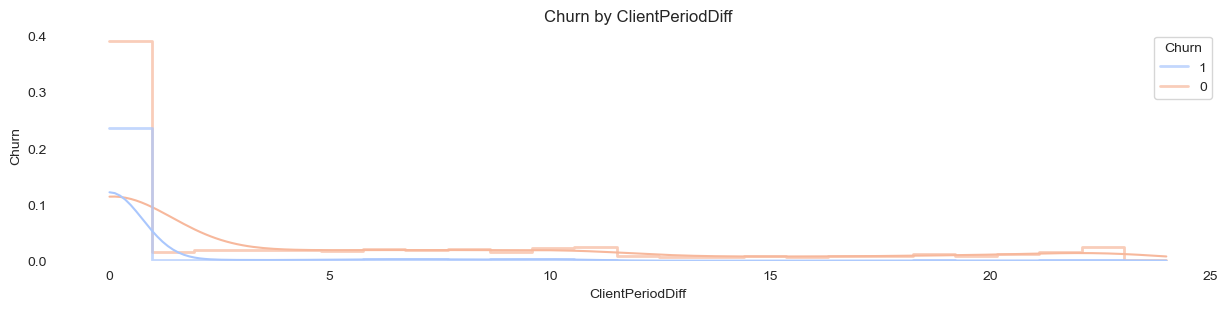

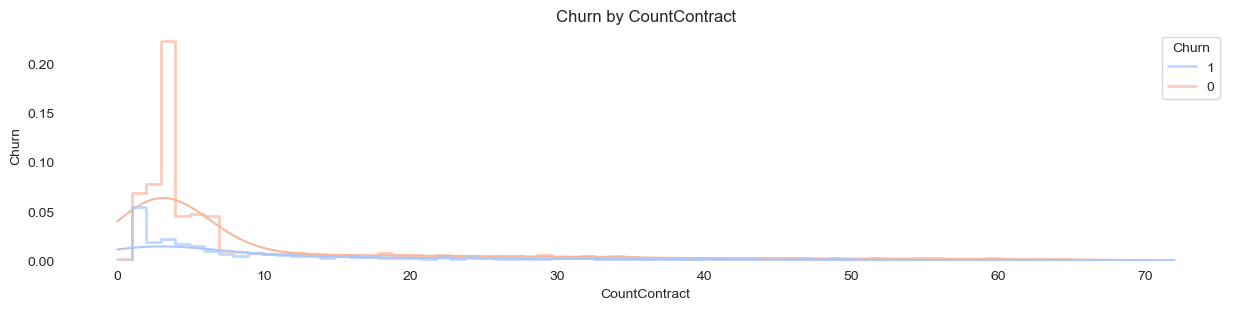

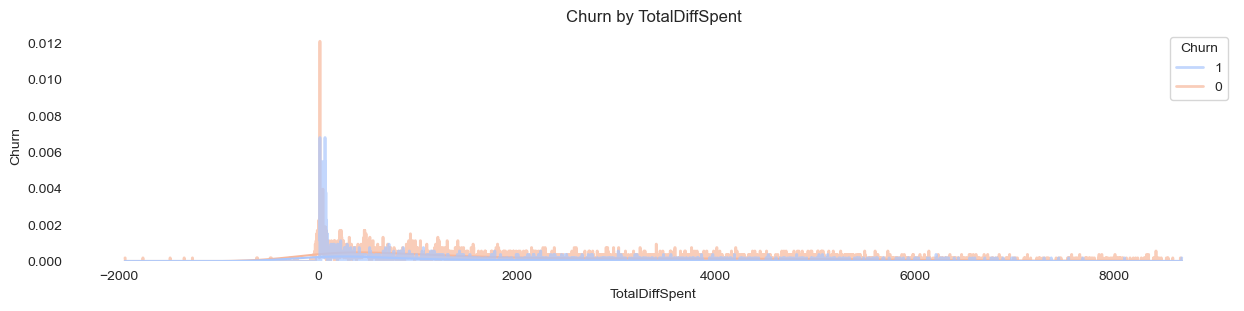

In [39]:
plot_hist_prob(df_train, "ClientPeriodContract")
plot_hist_prob(df_train, "ClientPeriodDiff")
plot_hist_prob(df_train, "CountContract")
plot_hist_prob(df_train, "TotalDiffSpent")

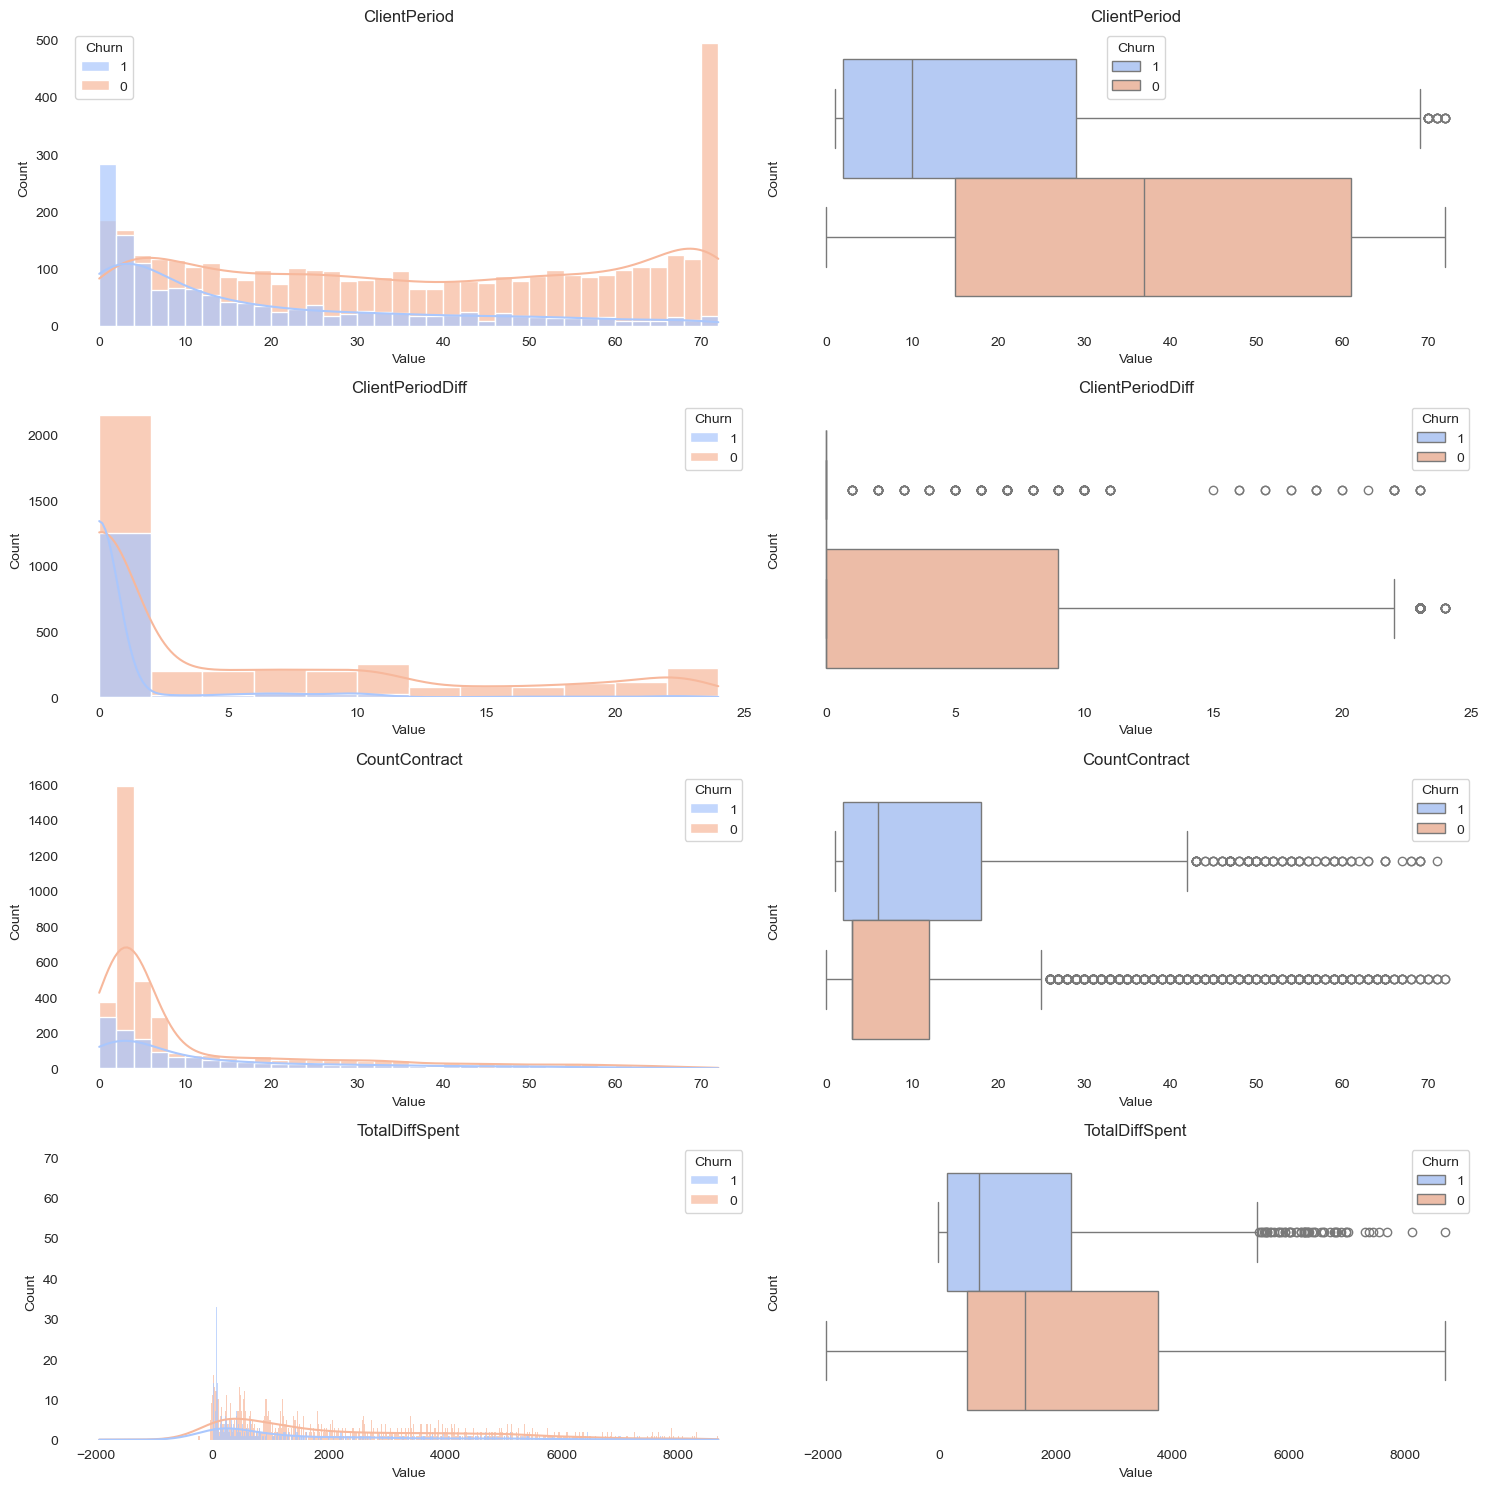

In [40]:
plot_num_data(df_train, ["ClientPeriod", "ClientPeriodDiff", "CountContract", "TotalDiffSpent"])

**Наблюдения:**

1. Явно подтвердить гипотезу не удалось. Есть зависимость вероятности ухода после 7-8 циклов контракта, но она не такая явная.
2. Возможно стоит рассмотреть другие типы визуализации.

#### 5.6.3. Target Feature

---

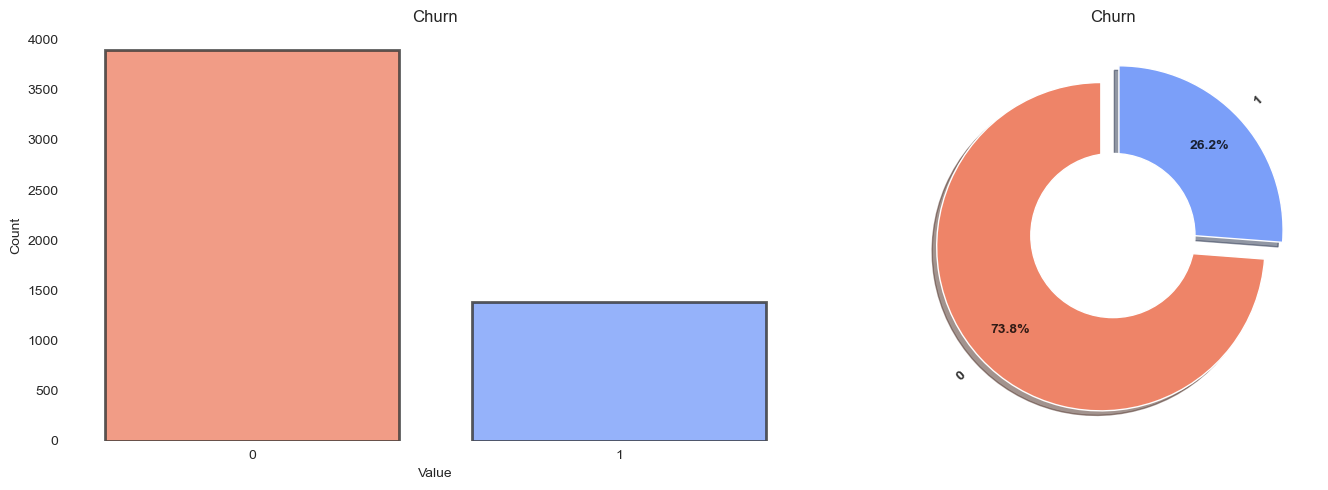

In [41]:
def plot_special_col(df_: pd.DataFrame, col_: str) -> None:
    value_count = df_[col_].value_counts()
    colors = cm.get_cmap("coolwarm")(np.linspace(0.8, 0.2, df_[col_].nunique()))
    colors_dct = {str(val): colors[ind] for ind, val in enumerate(value_count.index)}
    explode = [0.1 if val == value_count.max() else (0 + ind / 20) for ind, val in enumerate(value_count)]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    sns.barplot(
        x=value_count.index,
        y=value_count.values,
        palette=colors_dct,
        **plt_config_bar,
        ax=ax[0]
    )
    ax[0].set_title(col_)
    ax[0].set_xlabel("Value")
    ax[0].set_ylabel("Count")

    ax[1].pie(
        value_count.values,
        labels=colors_dct.keys(),
        explode=explode,
        colors=colors_dct.values(),
        **plt_config_pie
    )
    ax[1].set_title(col_)

    ax[1].add_artist(plt.Circle((0,0), 0.5, fc="white"))

    sns.despine(left=True, bottom=True)
    plt.grid(axis="y", alpha=0)
    plt.grid(axis="x", alpha=0)
    plt.tight_layout()
    plt.show()

plot_special_col(df_train, target_col)

**Наблюдения:**

1. Есть небольшое смещение к 0 классу, но не критичное.

### 5.7. Correlation Analysis

---

Закодируем категориальные признаки с помощью one-hot-encoding'а:

In [42]:
def one_hot_encode(df_: pd.DataFrame) -> pd.DataFrame:
    print(f"Кол-во признаков до one-hot-encoding'а: {df_.shape[1]}")
    df_ = pd.get_dummies(df_, columns=df_.select_dtypes("category").columns, dtype="int8")
    print(f"Кол-во признаков после one-hot-encoding'а: {df_.shape[1]}")
    return df_

df_train = one_hot_encode(df_train)
df_train.head()

Кол-во признаков до one-hot-encoding'а: 27
Кол-во признаков после one-hot-encoding'а: 35


ClientPeriod  MonthlySpending  TotalSpent  IsSeniorCitizen  HasPartner  \
0            55            19.50     1026.35                0           1   
1            72            25.85     1872.20                0           1   
2             1            75.90       75.90                0           0   
3            32            79.30     2570.00                1           1   
4            60           115.25     6758.45                0           1   

   HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
0         1                1                        0   
1         0                1                        1   
2         0                1                        0   
3         0                1                        1   
4         1                1                        1   

   HasOnlineSecurityService  HasOnlineBackup  ...  HasInternetService_DSL  \
0                         0                0  ...                       0   
1                         0                0  ...                       0   
2                         0                0  ...                       0   
3                         0                0  ...                       0   
4                         1                1  ...                       0   

   HasInternetService_Fiber optic  HasInternetService_No internet service  \
0                               0                                       1   
1                               0                                       1   
2                               1                                       0   
3                               1                                       0   
4                               1                                       0   

   HasContractPhone_Month-to-month  HasContractPhone_One year  \
0                                0                          1   
1                                0                          0   
2                                1                          0   
3                                1                          0   
4                                0                          0   

   HasContractPhone_Two year  PaymentMethod_Bank transfer  \
0                          0                            0   
1                          1                            0   
2                          0                            0   
3                          0                            0   
4                          1                            0   

   PaymentMethod_Credit card  PaymentMethod_Electronic check  \
0                          0                               0   
1                          1                               0   
2                          0                               1   
3                          0                               0   
4                          1                               0   

   PaymentMethod_Mailed check  
0                           1  
1                           0  
2                           0  
3                           1  
4                           0  

[5 rows x 35 columns]

Посмотрим на корреляцию признаков:

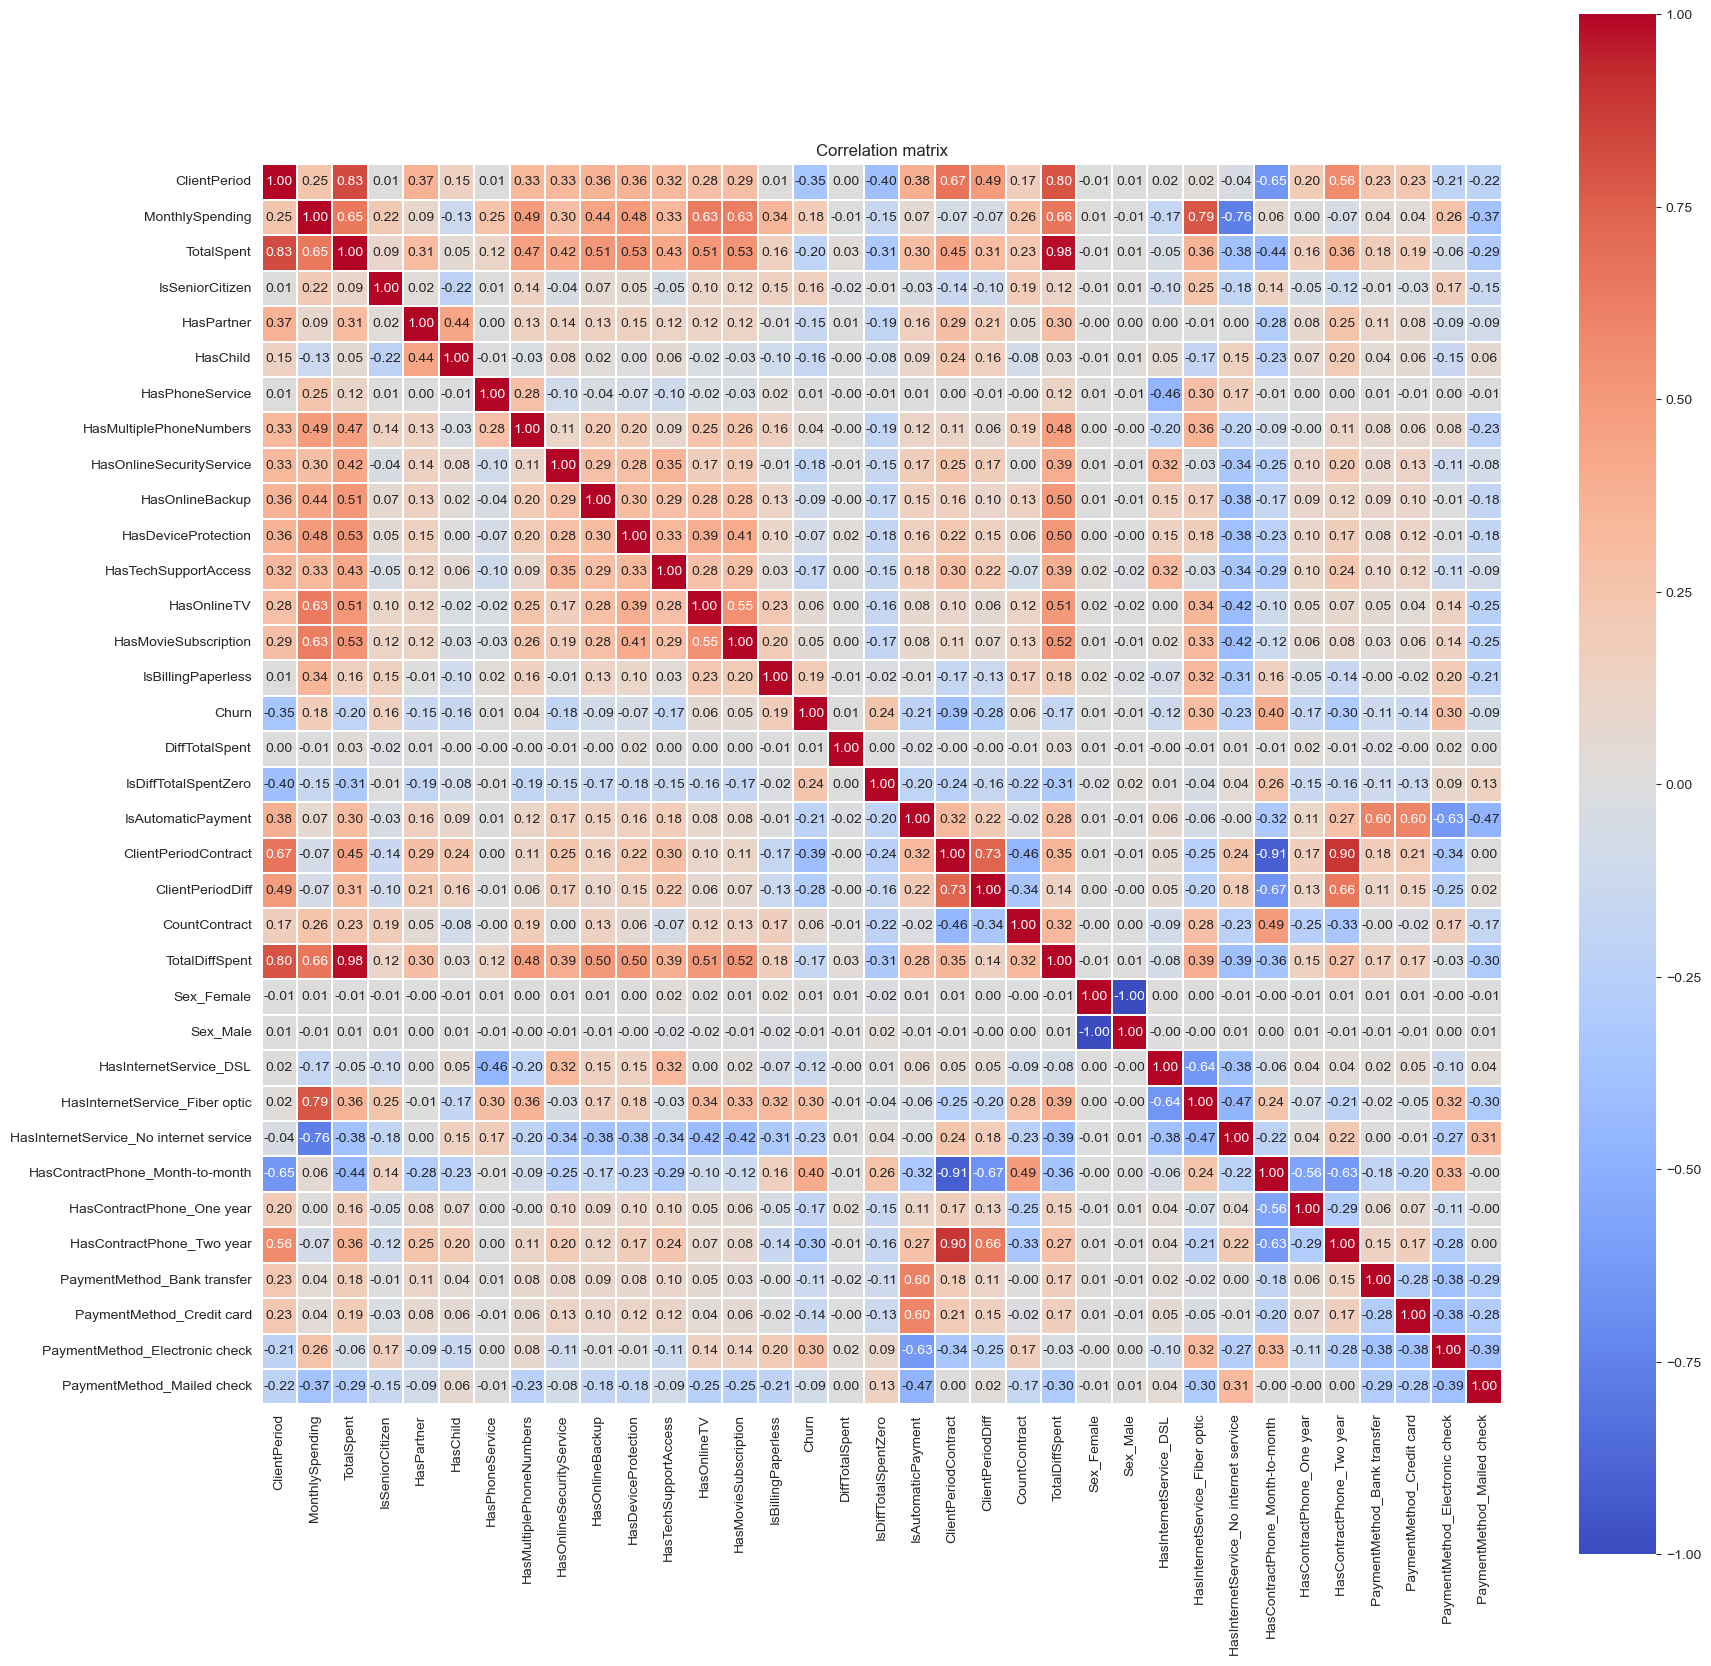

In [43]:
def plot_corr(df_: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(
        df_.corr(),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.1,
        linecolor="white",
        square=True,
        ax=ax
    )
    
    plt.title("Correlation matrix")
    plt.show()


plot_corr(df_train)

**Наблюдения:**

1. Churn неожиданно имеет корреляцию с **HasContractPhone_Month-to-month**. Возможно, это связано с тем, что клиенты, которые заключают контракт на 1 месяц чаще уходят.
2. В свою очередь **HasContractPhone_Month-to-month** отрицательно коррелирует с **TotalSpent** и **ClientPeriod**. 


Выведем наиболее значимые признаки:

In [44]:
df_train.corr()[target_col].sort_values(ascending=False).head(10)

Churn                              1.000000
HasContractPhone_Month-to-month    0.403429
HasInternetService_Fiber optic     0.300399
PaymentMethod_Electronic check     0.296715
IsDiffTotalSpentZero               0.243610
IsBillingPaperless                 0.194040
MonthlySpending                    0.184769
IsSeniorCitizen                    0.156872
HasOnlineTV                        0.059193
CountContract                      0.058631
Name: Churn, dtype: float64

In [45]:
df_train.corr()[target_col].sort_values(ascending=False).tail(10)

TotalDiffSpent                           -0.171550
HasContractPhone_One year                -0.174425
HasOnlineSecurityService                 -0.182871
TotalSpent                               -0.200033
IsAutomaticPayment                       -0.211138
HasInternetService_No internet service   -0.226991
ClientPeriodDiff                         -0.280760
HasContractPhone_Two year                -0.303830
ClientPeriod                             -0.350640
ClientPeriodContract                     -0.393517
Name: Churn, dtype: float64

## 6. Modeling

---

In [59]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, PredefinedSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline

### 6.1. Split Data

---

Разделим данные на train/valid выборку:

In [47]:
def split_train_test(X_: pd.DataFrame, y_: np.array, part_size_: float) -> tuple:
    seed_everything(42)
    return train_test_split(X_, y_, test_size=part_size_, random_state=42, stratify=y_, shuffle=True)

def split_train_val_test(X_: pd.DataFrame, y_: np.array) -> tuple:
    X_train_, X_test_, y_train_, y_test_ = split_train_test(X_, y_, part_size_=0.4)
    X_val_, X_test_, y_val_, y_test_ = split_train_test(X_test_, y_test_, part_size_=0.5)
    
    print(f"X Train: {X_train_.shape}")
    print(f"y Train: {y_train_.shape}", end="\n\n")
    
    print(f"X Val:   {X_val_.shape}")
    print(f"y Val:   {y_val_.shape}", end="\n\n")
    
    print(f"X Test:  {X_test_.shape}")
    print(f"y Test:  {y_test_.shape}", end="\n\n")
    
    return X_train_, X_val_, X_test_, y_train_, y_val_, y_test_

### 6.2. Parameter Tuning (GridSearchCV)

---

Подберем гиперпараметр C с помощью кроссвалидации:

In [72]:
def plot_roc_auc(y_true_: np.array, y_pred_: np.array) -> None:
    fpr, tpr, _ = roc_curve(y_true_, y_pred_)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))

    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC-AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC")
    plt.legend(loc="lower right")

    plt.show()


def prepare_data(df_: pd.DataFrame, target_col_: bool = True, one_hot_: bool = True, valid_: bool = True, test_: bool = True):
    df_ = refactor_num_data(df_)
    df_ = refactor_cat_data(df_)
    df_ = refactor_client_period(df_)
    
    if one_hot_:
        df_ = one_hot_encode(df_)
    
    if target_col_:
        if valid_:
            return split_train_val_test(df_.drop(target_col, axis=1), df_[target_col])
        elif test_:
            return split_train_test(df_.drop(target_col, axis=1), df_[target_col], part_size_=0.8)
        else:
            return df_.drop(target_col, axis=1), df_[target_col]
    else:
        return df_
    

def find_best_C(df_: pd.DataFrame) -> GridSearchCV:
    seed_everything(42)
    
    X_, y_ = prepare_data(df_, valid_=False, test_=False)
    folds = KFold(n_splits=10, shuffle=True)
    
    # X_train_, X_val_, X_test_, y_train_, y_val_, y_test_ = prepare_data(df_)
    # ind_lst = np.array([(-1 if _ in X_val_.index else (1 if _ in X_train_.index else 0)) for _ in X_.index])
    # pds = PredefinedSplit(ind_lst)
    
    pipe = make_pipeline(
        MinMaxScaler(),
        # StandardScaler(),
        # PCA(),
        # PolynomialFeatures(),
        LogisticRegression()
    )

    parameters = [
        dict(
            # pca__n_components=list(range(1, 12, 1)),
            # polynomialfeatures__degree=[3, 4],
            logisticregression__C=[100, 10, 1, 0.1, 0.01, 0.001],
            logisticregression__class_weight=["balanced", None],
        )
    ]
    
    print(f"Начало обучения...")
    best_score = 0
    for score_ in ["roc_auc", "r2", "neg_mean_squared_error"]:
        print(f"Метрика: {score_}")
        grid_LR = GridSearchCV(
            estimator=pipe,
            param_grid=parameters,
            cv=folds,
            scoring=score_,
            n_jobs=-1,
            verbose=1,
            refit=True
        )
        grid_LR.fit(X_, y_)
        best_score = max(best_score, grid_LR.best_score_)

    print(f"Лучшая метрика:   {grid_LR.best_score_}")
    print(f"Лучшие параметры: {grid_LR.best_params_}")

    print(f"Обучение завершено")

    train_res = grid_LR.best_estimator_.predict_proba(X_)
    print(f"Метрика на обучении: {roc_auc_score(y_, train_res[:, 1])}")
    plot_roc_auc(y_, train_res[:, 1])
    
    # test_res = grid_LR.best_estimator_.predict_proba(X_test_)
    # print(f"Метрика на тесте:      {roc_auc_score(y_test_, test_res[:, 1])}")
    # plot_roc_auc(y_test_, test_res[:, 1])
    
    return grid_LR

Кол-во признаков до one-hot-encoding'а: 27
Кол-во признаков после one-hot-encoding'а: 35
Начало обучения...
Метрика: roc_auc
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/mac/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Метрика: r2
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/mac/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Метрика: neg_mean_squared_error
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/mac/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Лучшая метрика:   -0.19026930457696054
Лучшие параметры: {'logisticregression__C': 10, 'logisticregression__class_weight': None}
Обучение завершено
Метрика на обучении: 0.8541056514827524


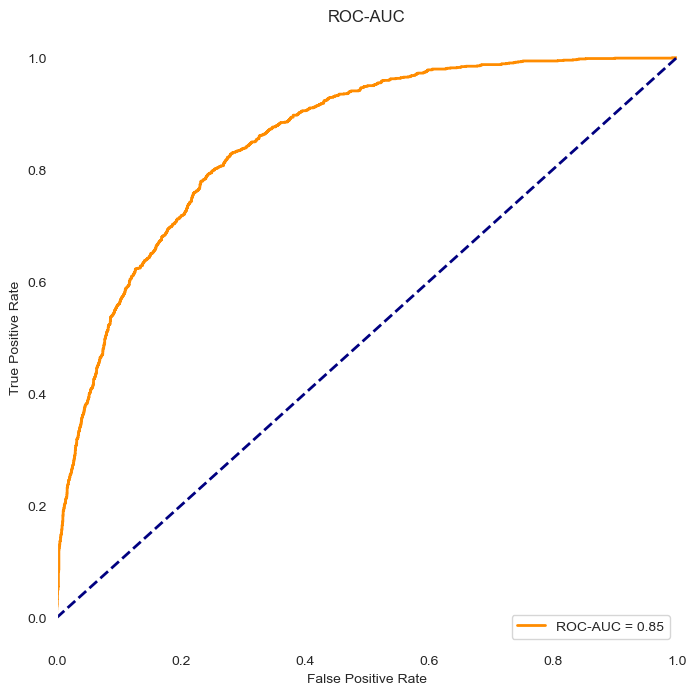

In [73]:
df = pd.read_csv("./data/train.csv")
best_model_lr = find_best_C(df)

Посмотрим на результаты на всем датасете:

Кол-во признаков до one-hot-encoding'а: 21
Кол-во признаков после one-hot-encoding'а: 29
X Train: (5273, 28)
y Train: (5273,)

Метрика на всем датасете: 0.8473712167265907


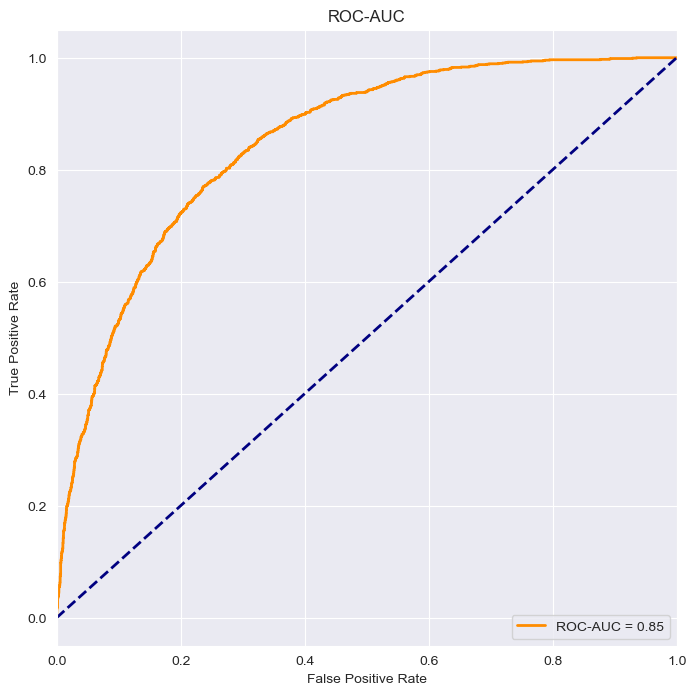

In [249]:
df = pd.read_csv("./data/train.csv")
df_X, _, _, df_y, _, _ = prepare_data(df, valid_=False, test_=False)

df_res = best_model_lr.best_estimator_.predict_proba(df_X)

print(f"Метрика на всем датасете: {roc_auc_score(df_y, df_res[:, 1])}")
plot_roc_auc(df_y, df_res[:, 1])

Лучшее качество и параметры с которыми удалось его достичь:

**Лучшие параметры `C`**: 10
**Метрика**: `roc_auc`
**Метрика на обучении**: 0.8541056514827524
**Метрика на Kaggle**: 0.84698

### 6.3. Feature Selection (CatBoost)

---

In [138]:
import catboost as cb

In [252]:
def train_alg(df_: pd.DataFrame, valid_: bool = True, test_: bool = True):
    seed_everything(42)
    
    X_train_, X_val_, X_test_, y_train_, y_val_, y_test_ = prepare_data(df_, one_hot_=False, valid_=valid_, test_=test_)
    
    cat_boost = cb.CatBoostClassifier(
        random_state=42,
        cat_features=X_train_.select_dtypes("category").columns.tolist(),
    )
    
    print("Начало обучения...")
    grid_ = RandomizedSearchCV(
        cat_boost,
        param_distributions = {
            "max_depth": range(1, 15),
            "learning_rate": np.linspace(0.0001, 0.1, 100),
            "n_estimators": range(1, 500)
        },
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        return_train_score=True,
        n_iter=30,
        verbose=1,
        refit=True
    )

    grid_.fit(X_train_, y_train_)

    print(f"Лучшая метрика:   {grid_.best_score_}")
    print(f"Лучшие параметры: {grid_.best_params_}")

    print(f"Обучение завершено")

    train_res = grid_.best_estimator_.predict_proba(X_train_)
    print(f"Метрика на обучении: {roc_auc_score(y_train_, train_res[:, 1])}")
    plot_roc_auc(y_train_, train_res[:, 1])
    
    if valid_:
        val_res = grid_.best_estimator_.predict_proba(X_val_)
        print(f"Метрика на валидации: {roc_auc_score(y_val_, val_res[:, 1])}")
        plot_roc_auc(y_val_, val_res[:, 1])
    
    if test_:
        test_res = grid_.best_estimator_.predict_proba(X_test_)
        print(f"Метрика на тесте:      {roc_auc_score(y_test_, test_res[:, 1])}")
        plot_roc_auc(y_test_, test_res[:, 1])
    
    return grid_

X Train: (5273, 20)
y Train: (5273,)

Начало обучения...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 0.6521408	total: 60.3ms	remaining: 0us
0:	learn: 0.6797195	total: 209ms	remaining: 41s
1:	learn: 0.6668435	total: 394ms	remaining: 38.4s
2:	learn: 0.6547553	total: 541ms	remaining: 35s
3:	learn: 0.6439339	total: 678ms	remaining: 32.7s
4:	learn: 0.6327566	total: 800ms	remaining: 30.7s
5:	learn: 0.6220780	total: 908ms	remaining: 28.9s
6:	learn: 0.6120576	total: 1.03s	remaining: 28.1s
7:	learn: 0.6019669	total: 1.13s	remaining: 26.8s
8:	learn: 0.5939755	total: 1.14s	remaining: 23.8s
9:	learn: 0.5848577	total: 1.31s	remaining: 24.5s
10:	learn: 0.5774729	total: 1.34s	remaining: 22.6s
11:	learn: 0.5698424	total: 1.48s	remaining: 22.9s
12:	learn: 0.5620228	total: 1.64s	remaining: 23.2s
13:	learn: 0.5537157	total: 1.8s	remaining: 23.6s
14:	learn: 0.5465768	total: 1.93s	remaining: 23.4s
15:	learn: 0.5393409	total: 2.05s	remaining: 23.2s
16:	learn: 0.5323744	total: 2.1

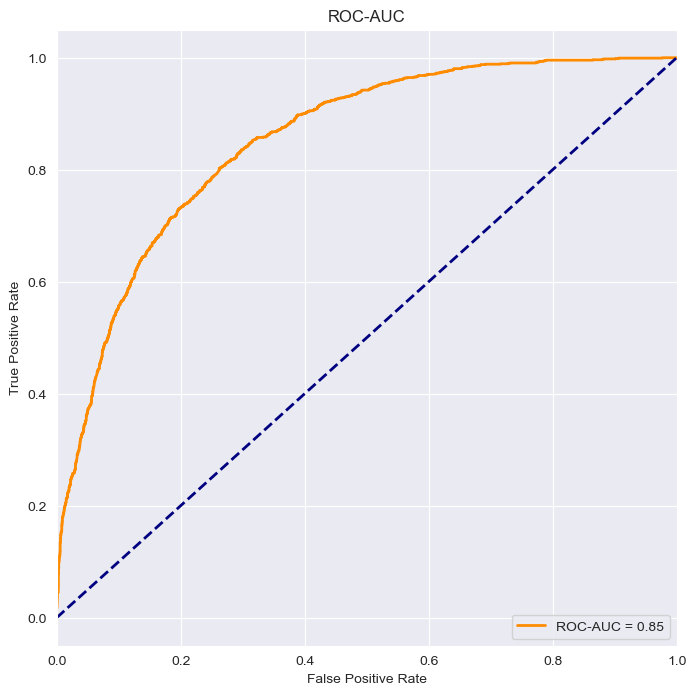

In [253]:
df = pd.read_csv("./data/train.csv")
best_model_cb = train_alg(df, valid_=False, test_=False)

Проверим на всем датасете:

X Train: (5282, 20)
y Train: (5282,)

Метрика на всем датасете: 0.8513187250316598


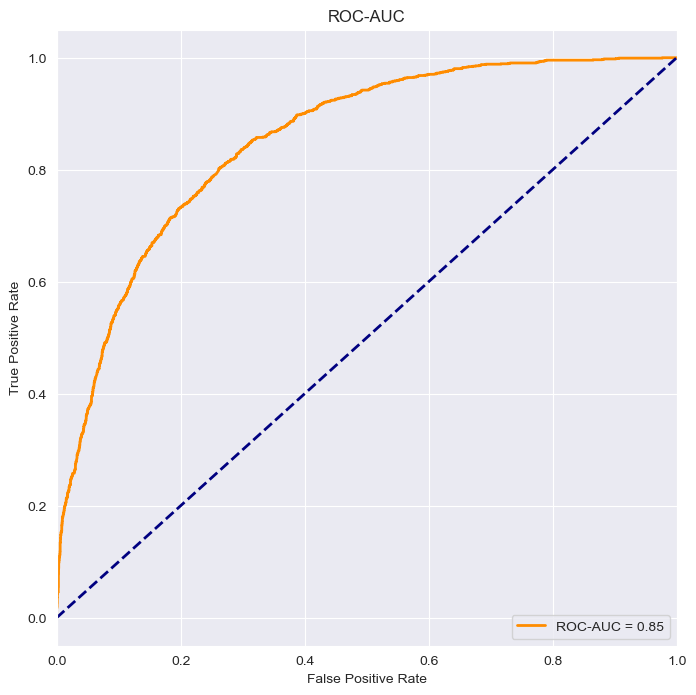

In [254]:
df = pd.read_csv("./data/train.csv")
df_X, _, _, df_y, _, _ = prepare_data(df, valid_=False, test_=False, one_hot_=False, slice_=False)

df_res = best_model_cb.best_estimator_.predict_proba(df_X)

print(f"Метрика на всем датасете: {roc_auc_score(df_y, df_res[:, 1])}")
plot_roc_auc(df_y, df_res[:, 1])

In [255]:
best_model_cb.best_estimator_.save_model("./catboost_model_5.cbm")

Лучшее качество и параметры с которыми удалось его достичь:

**Лучшие параметры `n_estimators`, `max_depth`, `learning_rate`**: 198, 2, 0.03743636363636364
**Метрика**: `roc_auc`
**Метрика на обучении**: 0.8510998674191472
**Метрика на Kaggle**: 0.85126


# Предсказания

---


Загрузим лучшую модель катбуста:

In [256]:
best_model = best_model_cb.best_estimator_

In [257]:
X_test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

# best_model.predict_proba(X_test) / best_model.predict(X_test)
submission['Churn'] = best_model.predict_proba(
    prepare_data(X_test, target_col_=False, slice_=False, valid_=False, test_=False, one_hot_=False)[0]
)[:, 1]
submission.to_csv('./data/my_submission_cb_7.csv', index=False)

X Train: (1761, 20)


Загрузим лучшую модель логистической регрессии:

In [121]:
best_model = best_model_lr.best_estimator_

In [122]:
X_test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

# best_model.predict_proba(X_test) / best_model.predict(X_test)
submission['Churn'] = best_model.predict_proba(
    prepare_data(X_test, target_col_=False, valid_=False, test_=False)
)[:, 1]
submission.to_csv('./data/submission_lr_v2.csv', index=False)

Кол-во признаков до one-hot-encoding'а: 26
Кол-во признаков после one-hot-encoding'а: 34


# Выводы

---

1) Лучшая модель - CatBoostClassifier с параметрами `n_estimators=198`, `max_depth=2`, `learning_rate=0.03743636363636364`. Метрика на всем датасете: 0.8513187250316598.
2) Лучшая модель логистической регрессии - LogisticRegression с параметром `C=10`. Метрика на всем датасете: 0.8471204147924748.
3) Признаки **ClientPeriod**, **MonthlySpending**, **TotalSpent** имеют наибольшую корреляцию с целевой переменной.
4) Признаки **ClientPeriod**, **MonthlySpending**, **TotalSpent** имеют смещение влево, поэтому их лучше нормализовать.
5) Лучшая модель катбуста показала лучший результат при обучении на всем датафрейме (без train/valid выборки).

# Комментарии к решению от проверяющих

---

> ## № 1 
> --- С точки зрения количества усилий и кодстайла - просто роскошно, очень хорошо.
> Разве что я бы посоветовал все таки попробовать оптуну для тюнинга параметров.
> Также в кэтбуст можно сразу же передавать валидационный сет для лучшего обучения - и в принципе выбирать метрику.
> Это особенно хорошего если ты прям КОНКРЕТНО тюнишь гиперпараметры, тк помогает делать early stopping. 

> ## № 2
> --- Не согласен с подходом применения кросс валидации вместе с разбиением train на train и valid. Кросс валидация более затратный процесс и тестирование модели позже на отдельной валидационной выборке излишне. Остальное выполнено верно.

> ## № 3
> --- В целом все прекрасно, можно добавить early_stopping_rounds, может сократить время обучения)
